## 1. Φόρτωση Βιβλιοθηκών

In [679]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Ρυθμίσεις για καλύτερη απεικόνιση
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')

## 2. Φόρτωση Δεδομένων

In [680]:
# Φόρτωση του dataset
df = pd.read_csv('project_cluster.csv')

print(f"Διαστάσεις dataset: {df.shape}")
print(f"\nΠρώτες 5 γραμμές:")
df.head()

Διαστάσεις dataset: (2000, 17)

Πρώτες 5 γραμμές:


,Booking_ID,number.of.adults,number.of.children,number.of.weekend.nights,number.of.week.nights,type.of.meal,car.parking.space,room.type,lead.time,market.segment.type,repeated,P.C,P.not.C,average.price,special.requests,date.of.reservation,booking.status
0,BID19169,2,0,1,0,Meal Plan 1,0,Room_Type 1,0,Online,0,0,0,115.0,1,10/8/2017,Not_Canceled
1,BID26830,2,0,1,4,Meal Plan 1,0,Room_Type 1,11,Online,0,0,0,90.0,2,8/17/2017,Canceled
2,BID00278,1,0,2,1,Meal Plan 1,0,Room_Type 1,33,Online,0,0,0,82.9,2,5/3/2018,Not_Canceled
3,BID22091,2,0,0,1,Meal Plan 2,0,Room_Type 1,55,Offline,0,0,0,104.0,0,6/4/2018,Not_Canceled
4,BID17706,2,1,0,2,Meal Plan 1,0,Room_Type 1,138,Online,0,0,0,139.5,1,9/8/2018,Not_Canceled


In [681]:
# Γενικές πληροφορίες
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                2000 non-null   object 
 1   number.of.adults          2000 non-null   int64  
 2   number.of.children        2000 non-null   int64  
 3   number.of.weekend.nights  2000 non-null   int64  
 4   number.of.week.nights     2000 non-null   int64  
 5   type.of.meal              2000 non-null   object 
 6   car.parking.space         2000 non-null   int64  
 7   room.type                 2000 non-null   object 
 8   lead.time                 2000 non-null   int64  
 9   market.segment.type       2000 non-null   object 
 10  repeated                  2000 non-null   int64  
 11  P.C                       2000 non-null   int64  
 12  P.not.C                   2000 non-null   int64  
 13  average.price             2000 non-null   float64
 14  special.

In [682]:
# Έλεγχος για missing values
print("Missing values ανά στήλη:")
df.isnull().sum()

Missing values ανά στήλη:


Booking_ID                  0
number.of.adults            0
number.of.children          0
number.of.weekend.nights    0
number.of.week.nights       0
type.of.meal                0
car.parking.space           0
room.type                   0
lead.time                   0
market.segment.type         0
repeated                    0
P.C                         0
P.not.C                     0
average.price               0
special.requests            0
date.of.reservation         0
booking.status              0
dtype: int64

## 3. Feature Engineering

Δημιουργία νέων μεταβλητών σύμφωνα με το `notes.md`.

In [683]:
# Δημιουργία αντιγράφου για το preprocessing
df_processed = df.copy()

# 1. Total Guests
df_processed['Total_Guests'] = df_processed['number.of.adults'] + df_processed['number.of.children']

# 2. Is_Family (binary)
df_processed['Is_Family'] = (df_processed['number.of.children'] > 0).astype(int)

# 3. Total Nights
df_processed['Total_Nights'] = df_processed['number.of.weekend.nights'] + df_processed['number.of.week.nights']

# 4. Cancellation Ratio (για returning customers)
df_processed['Cancellation_Ratio'] = (df_processed['P.C'] + 1) / (df_processed['P.not.C'] + df_processed['P.C'] + 2)

# 5. Price per Person
df_processed['Price_per_Person'] = df_processed['average.price'] / df_processed['Total_Guests']
# Αντιμετώπιση περιπτώσεων με 0 guests (αν υπάρχουν)
df_processed['Price_per_Person'].replace([np.inf, -np.inf], np.nan, inplace=True)

# 6. Arrival Month (από date.of.reservation + lead.time)
# Συνάρτηση για διόρθωση μη έγκυρων ημερομηνιών
def fix_invalid_date(date_str):
    """Προσπαθεί να διορθώσει μη έγκυρες ημερομηνίες μειώνοντας την ημέρα κατά 1"""
    try:
        return pd.to_datetime(date_str)
    except:
        # Προσπάθεια να αναλύσουμε την ημερομηνία χειροκίνητα
        try:
            date_str = str(date_str)
            # Έλεγχος για μορφή M/D/YYYY
            if '/' in date_str:
                parts = date_str.split('/')
                month, day, year = int(parts[0]), int(parts[1]), int(parts[2])
            # Έλεγχος για μορφή YYYY-M-D ή YYYY-MM-DD
            elif '-' in date_str:
                parts = date_str.split('-')
                year, month, day = int(parts[0]), int(parts[1]), int(parts[2])
            else:
                return pd.NaT
            
            # Προσπαθούμε να δημιουργήσουμε την ημερομηνία, μειώνοντας την ημέρα αν χρειάζεται
            while day > 0:
                try:
                    return pd.Timestamp(year=year, month=month, day=day)
                except:
                    day -= 1
        except:
            pass
        return pd.NaT

# Εφαρμογή της διόρθωσης
df_processed['date.of.reservation'] = df_processed['date.of.reservation'].apply(fix_invalid_date)

# Υπολογισμός Arrival Date και Off_Season
df_processed['Arrival_Date'] = df_processed['date.of.reservation'] + pd.to_timedelta(df_processed['lead.time'], unit='D')
df_processed['Arrival_Month'] = df_processed['Arrival_Date'].dt.month

# 6. Off_Season: 0 αν μήνας είναι 3,4,5,8,9 (off-season), 1 αλλιώς (peak season)
df_processed['Off_Season'] = df_processed['Arrival_Month'].apply(
    lambda x: 0 if x in [3, 4, 5, 8, 9] else 1
)

# Έλεγχος για ημερομηνίες που δεν μπόρεσαν να διορθωθούν
invalid_dates = df_processed['date.of.reservation'].isna().sum()
if invalid_dates > 0:
    print(f"Προσοχή: {invalid_dates} ημερομηνίες δεν μπόρεσαν να διορθωθούν")
else:
    print("Όλες οι ημερομηνίες διορθώθηκαν επιτυχώς!")

print("Νέες μεταβλητές δημιουργήθηκαν επιτυχώς!")
print(f"Off_Season: 0 = μήνες 3,4,5,8,9 (off-season), 1 = υπόλοιποι μήνες (peak season)")
print(f"\nΝέες διαστάσεις: {df_processed.shape}")

Όλες οι ημερομηνίες διορθώθηκαν επιτυχώς!
Νέες μεταβλητές δημιουργήθηκαν επιτυχώς!
Off_Season: 0 = μήνες 3,4,5,8,9 (off-season), 1 = υπόλοιποι μήνες (peak season)

Νέες διαστάσεις: (2000, 25)


In [684]:
# Εμφάνιση των νέων features
new_features = ['Total_Guests', 'Is_Family', 'Total_Nights', 'Cancellation_Ratio', 
                'Price_per_Person', 'Off_Season']
df_processed[new_features].head()

,Total_Guests,Is_Family,Total_Nights,Cancellation_Ratio,Price_per_Person,Off_Season
0,2,0,1,0.5,57.5,1
1,2,0,5,0.5,45.0,0
2,1,0,3,0.5,82.9,1
3,2,0,1,0.5,52.0,1
4,3,1,2,0.5,46.5,1


In [685]:
# 1. number.of.children: 0, 1+ (αντί για 0,1,2,3)
df_processed['number.of.children'] = df_processed['number.of.children'].apply(
    lambda x: 0 if x == 0 else 1
)

# 2. number.of.weekend.nights: 0, 1, 2, 3+
df_processed['number.of.weekend.nights'] = df_processed['number.of.weekend.nights'].apply(
    lambda x: min(x, 3)
)

# 3. number.of.week.nights: κανονικά ως το 5, μετά 6+
df_processed['number.of.week.nights'] = df_processed['number.of.week.nights'].apply(
    lambda x: min(x, 6)
)

# 4. P.C: 0, 1+
df_processed['P.C'] = df_processed['P.C'].apply(
    lambda x: 0 if x == 0 else 1
)

# 5. P.not.C: 0, 1+
df_processed['P.not.C'] = df_processed['P.not.C'].apply(
    lambda x: 0 if x == 0 else 1
)

# 6. Total_Guests: (όσα είναι 0 κάντα 1), 1, 2, 3+
df_processed['Total_Guests'] = df_processed['Total_Guests'].apply(
    lambda x: 1 if x == 0 else min(x, 3)
)

# 7. Total_Nights: από 8 και πάνω βάλε τιμή 8+
# Πρώτα διόρθωση για τυχόν float values (round)
df_processed['Total_Nights'] = df_processed['Total_Nights'].round().astype(int)
df_processed['Total_Nights'] = df_processed['Total_Nights'].apply(
    lambda x: min(x, 8)
)

print("Ομαδοποίηση τιμών ολοκληρώθηκε!")
print("\nΝέες κατανομές:")
print(f"number.of.children: {sorted(df_processed['number.of.children'].unique())}")
print(f"number.of.weekend.nights: {sorted(df_processed['number.of.weekend.nights'].unique())}")
print(f"number.of.week.nights: {sorted(df_processed['number.of.week.nights'].unique())}")
print(f"P.C: {sorted(df_processed['P.C'].unique())}")
print(f"P.not.C: {sorted(df_processed['P.not.C'].unique())}")
print(f"Total_Guests: {sorted(df_processed['Total_Guests'].unique())}")
print(f"Total_Nights: {sorted(df_processed['Total_Nights'].unique())}")

Ομαδοποίηση τιμών ολοκληρώθηκε!

Νέες κατανομές:
number.of.children: [np.int64(0), np.int64(1)]
number.of.weekend.nights: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
number.of.week.nights: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
P.C: [np.int64(0), np.int64(1)]
P.not.C: [np.int64(0), np.int64(1)]
Total_Guests: [np.int64(1), np.int64(2), np.int64(3)]
Total_Nights: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]


## 3.1 Ομαδοποίηση Τιμών (Binning)

Δημιουργία κατηγοριών για συγκεκριμένες μεταβλητές για καλύτερη ομαδοποίηση.

## 4. Αφαίρεση Περιττών Μεταβλητών

In [686]:
# Αποθήκευση του booking.status για μετέπειτα αξιολόγηση
booking_status = df_processed['booking.status'].copy()

# Μεταβλητές προς αφαίρεση
columns_to_drop = ['Booking_ID', 'booking.status', 'date.of.reservation', 'Arrival_Date']
df_processed = df_processed.drop(columns=columns_to_drop)

print(f"Διαστάσεις μετά την αφαίρεση: {df_processed.shape}")
print(f"\nΥπόλοιπες στήλες: {df_processed.columns.tolist()}")

Διαστάσεις μετά την αφαίρεση: (2000, 21)

Υπόλοιπες στήλες: ['number.of.adults', 'number.of.children', 'number.of.weekend.nights', 'number.of.week.nights', 'type.of.meal', 'car.parking.space', 'room.type', 'lead.time', 'market.segment.type', 'repeated', 'P.C', 'P.not.C', 'average.price', 'special.requests', 'Total_Guests', 'Is_Family', 'Total_Nights', 'Cancellation_Ratio', 'Price_per_Person', 'Arrival_Month', 'Off_Season']


## 5. One-Hot Encoding για Κατηγορικές Μεταβλητές

In [687]:
# Κατηγορικές μεταβλητές (αφαιρέθηκαν type.of.meal και room.type)
categorical_features = ['market.segment.type']

print("Μοναδικές τιμές κατηγορικών μεταβλητών:")
for col in categorical_features:
    print(f"\n{col}: {df_processed[col].unique()}")

Μοναδικές τιμές κατηγορικών μεταβλητών:

market.segment.type: ['Online' 'Offline' 'Corporate' 'Complementary' 'Aviation']


In [688]:
# One-hot encoding
df_encoded = pd.get_dummies(df_processed, columns=categorical_features, drop_first=True)

print(f"Διαστάσεις μετά το encoding: {df_encoded.shape}")
print(f"\nΌλες οι στήλες:")
print(df_encoded.columns.tolist())
print(f"Υπόλοιπες στήλες: {df_encoded.columns.tolist()}")
# Αφαίρεση των στηλών type.of.meal και room.type (και των παραγώγων τους)
print("\n" + "="*60)
print("ΑΦΑΙΡΕΣΗ ΜΕΤΑΒΛΗΤΩΝ type.of.meal ΚΑΙ room.type")
print("="*60)

# Βρίσκουμε όλες τις στήλες που ξεκινούν με 'type.of.meal' ή 'room.type'
cols_to_drop = [col for col in df_encoded.columns if col.startswith('type.of.meal') or col.startswith('room.type')]
print(f"\nΣτήλες που θα αφαιρεθούν ({len(cols_to_drop)}):")
print(f"\nΣτήλες που θα αφαιρεθούν ({len(cols_to_drop)}):")
for col in cols_to_drop:
    print(f"  - {col}")

# Αφαιρούμε τις στήλες
df_encoded = df_encoded.drop(columns=cols_to_drop)

print(f"\nΝέες διαστάσεις μετά την αφαίρεση: {df_encoded.shape}")
print(f"Υπόλοιπες στήλες: {df_encoded.columns.tolist()}")

Διαστάσεις μετά το encoding: (2000, 24)

Όλες οι στήλες:
['number.of.adults', 'number.of.children', 'number.of.weekend.nights', 'number.of.week.nights', 'type.of.meal', 'car.parking.space', 'room.type', 'lead.time', 'repeated', 'P.C', 'P.not.C', 'average.price', 'special.requests', 'Total_Guests', 'Is_Family', 'Total_Nights', 'Cancellation_Ratio', 'Price_per_Person', 'Arrival_Month', 'Off_Season', 'market.segment.type_Complementary', 'market.segment.type_Corporate', 'market.segment.type_Offline', 'market.segment.type_Online']
Υπόλοιπες στήλες: ['number.of.adults', 'number.of.children', 'number.of.weekend.nights', 'number.of.week.nights', 'type.of.meal', 'car.parking.space', 'room.type', 'lead.time', 'repeated', 'P.C', 'P.not.C', 'average.price', 'special.requests', 'Total_Guests', 'Is_Family', 'Total_Nights', 'Cancellation_Ratio', 'Price_per_Person', 'Arrival_Month', 'Off_Season', 'market.segment.type_Complementary', 'market.segment.type_Corporate', 'market.segment.type_Offline', 'mark

In [689]:
# Έλεγχος για NaN values
print("Missing values μετά το preprocessing:")
print(df_encoded.isnull().sum().sum())

# Αν υπάρχουν NaN, συμπληρώνουμε με τη μέση τιμή
if df_encoded.isnull().sum().sum() > 0:
    print("\nΣυμπλήρωση NaN με μέση τιμή...")
    df_encoded = df_encoded.fillna(df_encoded.mean())

Missing values μετά το preprocessing:
0


In [690]:
# Τελικό dataset για clustering
print("Τελικό dataset έτοιμο για clustering:")
print(f"Shape: {df_encoded.shape}")

#first 10 rows

df_encoded.head(20)

Τελικό dataset έτοιμο για clustering:
Shape: (2000, 22)


,number.of.adults,number.of.children,number.of.weekend.nights,number.of.week.nights,car.parking.space,lead.time,repeated,P.C,P.not.C,average.price,special.requests,Total_Guests,Is_Family,Total_Nights,Cancellation_Ratio,Price_per_Person,Arrival_Month,Off_Season,market.segment.type_Complementary,market.segment.type_Corporate,market.segment.type_Offline,market.segment.type_Online
0,2,0,1,0,0,0,0,0,0,115.00,1,2,0,1,0.500000,57.500000,10,1,False,False,False,True
1,2,0,1,4,0,11,0,0,0,90.00,2,2,0,5,0.500000,45.000000,8,0,False,False,False,True
2,1,0,2,1,0,33,0,0,0,82.90,2,1,0,3,0.500000,82.900000,6,1,False,False,False,True
3,2,0,0,1,0,55,0,0,0,104.00,0,2,0,1,0.500000,52.000000,7,1,False,False,True,False
4,2,1,0,2,0,138,0,0,0,139.50,1,3,1,2,0.500000,46.500000,1,1,False,False,False,True
5,3,0,0,3,0,160,0,0,0,137.70,0,3,0,3,0.500000,45.900000,12,1,False,False,False,True
6,1,0,1,1,0,3,1,0,1,89.50,1,1,0,2,0.333333,89.500000,12,1,False,False,False,True
7,2,0,0,3,0,107,0,0,0,58.00,0,2,0,3,0.500000,29.000000,7,1,False,False,True,False
8,1,0,1,1,0,17,0,0,0,114.73,1,1,0,2,0.500000,114.730000,12,1,False,False,False,True
9,2,0,0,3,0,18,0,0,0,12.00,2,2,0,3,0.500000,6.000000,2,1,False,False,False,True


In [691]:
from sklearn.preprocessing import MinMaxScaler

# Ρυθμίσεις για εμφάνιση όλων των στηλών
pd.set_option('display.max_columns', None)  # Εμφάνιση όλων των στηλών
pd.set_option('display.width', None)        # Αυτόματο πλάτος
pd.set_option('display.max_colwidth', None) # Πλήρες μήκος κάθε στήλης

# Δημιουργία scaler για εύρος [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))

# Εφαρμογή scaling
df_scaled_array = scaler.fit_transform(df_encoded)

# Δημιουργία DataFrame με τα scaled δεδομένα
df_scaled = pd.DataFrame(df_scaled_array, columns=df_encoded.columns)

print("Scaling ολοκληρώθηκε!")
print(f"Shape των scaled δεδομένων: {df_scaled.shape}")
print(f"\nΕύρος τιμών μετά το scaling:")
print(f"Min: {df_scaled.min().min():.4f}")
print(f"Max: {df_scaled.max().max():.4f}")
print(f"\nΠρώτες 5 γραμμές:")
df_scaled.head()

Scaling ολοκληρώθηκε!
Shape των scaled δεδομένων: (2000, 22)

Εύρος τιμών μετά το scaling:
Min: -1.0000
Max: 1.0000

Πρώτες 5 γραμμές:


,number.of.adults,number.of.children,number.of.weekend.nights,number.of.week.nights,car.parking.space,lead.time,repeated,P.C,P.not.C,average.price,special.requests,Total_Guests,Is_Family,Total_Nights,Cancellation_Ratio,Price_per_Person,Arrival_Month,Off_Season,market.segment.type_Complementary,market.segment.type_Corporate,market.segment.type_Offline,market.segment.type_Online
0,0.333333,-1.0,-0.333333,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-0.342162,-0.5,0.0,-1.0,-0.75,0.473684,-0.373638,0.636364,1.0,-1.0,-1.0,-1.0,1.0
1,0.333333,-1.0,-0.333333,0.333333,-1.0,-0.947368,-1.0,-1.0,-1.0,-0.485170,0.0,0.0,-1.0,0.25,0.473684,-0.509804,0.272727,-1.0,-1.0,-1.0,-1.0,1.0
2,-0.333333,-1.0,0.333333,-0.666667,-1.0,-0.842105,-1.0,-1.0,-1.0,-0.525784,0.0,-1.0,-1.0,-0.25,0.473684,-0.096950,-0.090909,1.0,-1.0,-1.0,-1.0,1.0
3,0.333333,-1.0,-1.000000,-0.666667,-1.0,-0.736842,-1.0,-1.0,-1.0,-0.405085,-1.0,0.0,-1.0,-0.75,0.473684,-0.433551,0.090909,1.0,-1.0,-1.0,1.0,-1.0
4,0.333333,1.0,-1.000000,-0.333333,-1.0,-0.339713,-1.0,-1.0,-1.0,-0.202014,-0.5,1.0,1.0,-0.50,0.473684,-0.493464,-1.000000,1.0,-1.0,-1.0,-1.0,1.0


In [692]:
# Λίστα με τις αρχικές αριθμητικές μεταβλητές (πριν το one-hot encoding)
original_numeric_cols = [
    'number.of.adults', 'number.of.children', 'number.of.weekend.nights', 
    'number.of.week.nights', 'car.parking.space', 'lead.time', 'repeated',
    'P.C', 'P.not.C', 'average.price', 'special.requests',
    'Total_Guests', 'Is_Family', 'Total_Nights', 'Cancellation_Ratio',
    'Price_per_Person', 'Off_Season'
]

print(f"Θα δημιουργηθούν ιστογράμματα για {len(original_numeric_cols)} scaled μεταβλητές")

Θα δημιουργηθούν ιστογράμματα για 17 scaled μεταβλητές


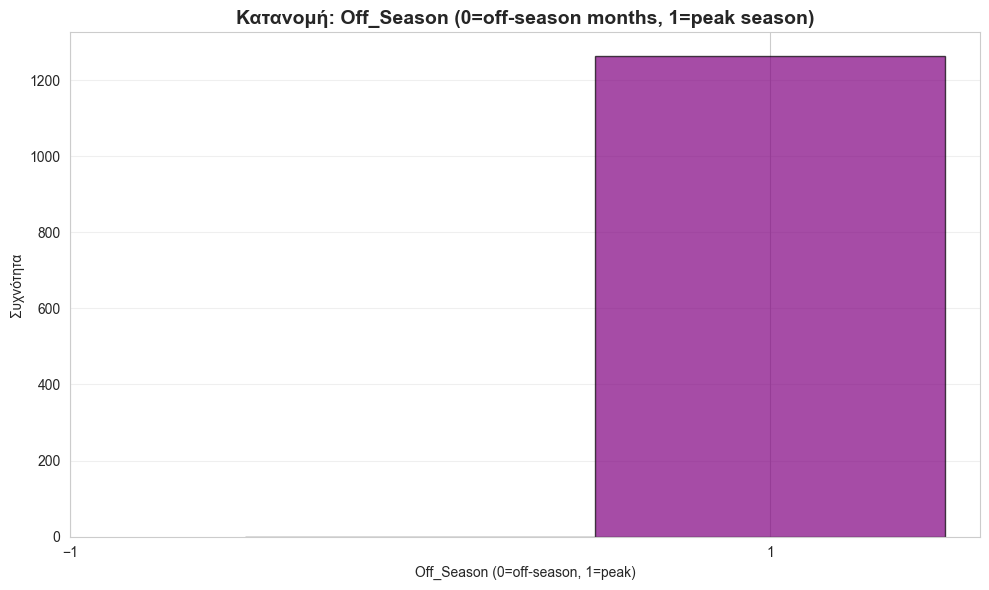

In [693]:
# Ιστόγραμμα για Off_Season (binary: 0=off-season, 1=peak season)
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_scaled['Off_Season'].unique())
bins = [x - 0.5 for x in range(int(df_scaled['Off_Season'].max()) + 2)]
plt.hist(df_scaled['Off_Season'], bins=bins, edgecolor='black', alpha=0.7, color='purple', align='mid')
plt.title('Κατανομή: Off_Season (0=off-season months, 1=peak season)', fontsize=14, fontweight='bold')
plt.xlabel('Off_Season (0=off-season, 1=peak)')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

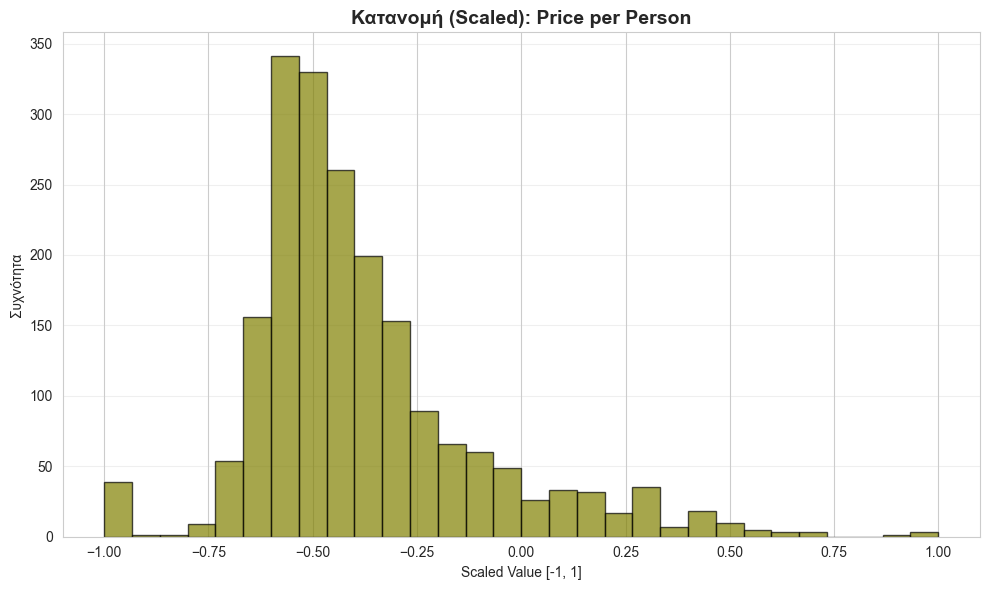

In [694]:
# Ιστόγραμμα για Price_per_Person (scaled)
plt.figure(figsize=(10, 6))
plt.hist(df_scaled['Price_per_Person'], bins=30, edgecolor='black', alpha=0.7, color='olive')
plt.title('Κατανομή (Scaled): Price per Person', fontsize=14, fontweight='bold')
plt.xlabel('Scaled Value [-1, 1]')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

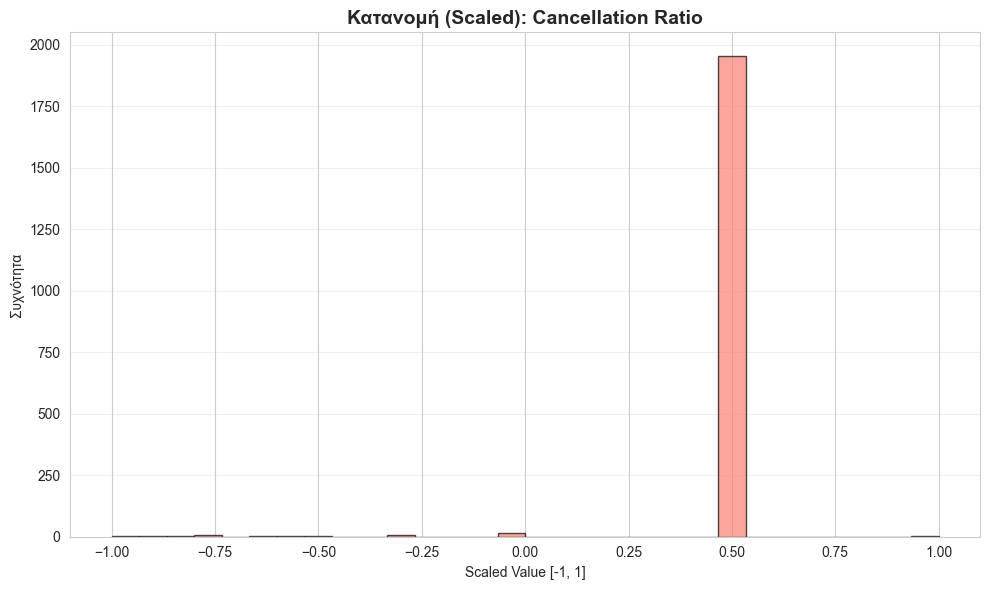

In [695]:
# Ιστόγραμμα για Cancellation_Ratio (scaled)
plt.figure(figsize=(10, 6))
plt.hist(df_scaled['Cancellation_Ratio'], bins=30, edgecolor='black', alpha=0.7, color='salmon')
plt.title('Κατανομή (Scaled): Cancellation Ratio', fontsize=14, fontweight='bold')
plt.xlabel('Scaled Value [-1, 1]')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

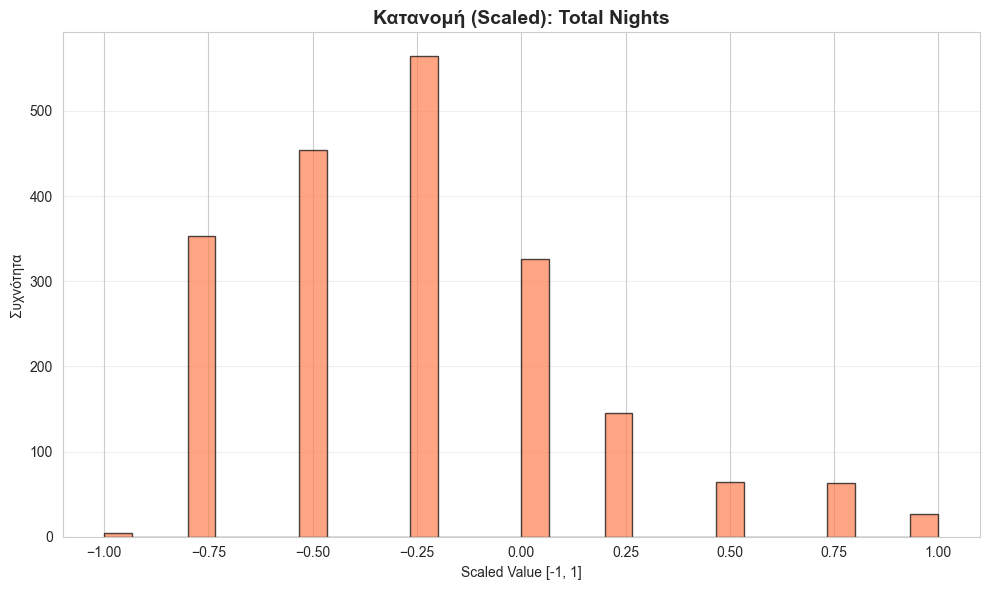

In [696]:
# Ιστόγραμμα για Total_Nights (scaled)
plt.figure(figsize=(10, 6))
plt.hist(df_scaled['Total_Nights'], bins=30, edgecolor='black', alpha=0.7, color='coral')
plt.title('Κατανομή (Scaled): Total Nights', fontsize=14, fontweight='bold')
plt.xlabel('Scaled Value [-1, 1]')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

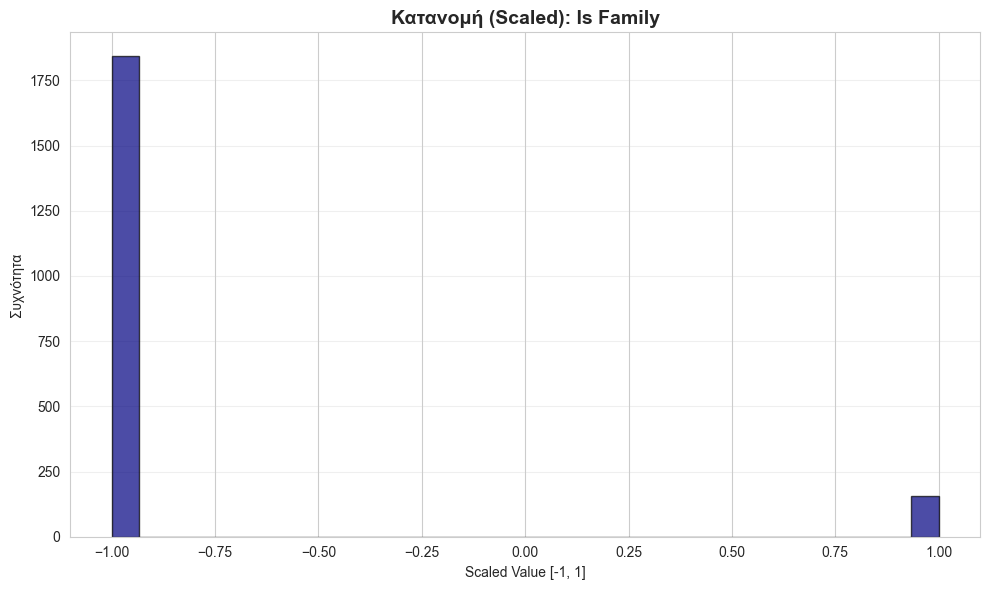

In [697]:
# Ιστόγραμμα για Is_Family (scaled)
plt.figure(figsize=(10, 6))
plt.hist(df_scaled['Is_Family'], bins=30, edgecolor='black', alpha=0.7, color='navy')
plt.title('Κατανομή (Scaled): Is Family', fontsize=14, fontweight='bold')
plt.xlabel('Scaled Value [-1, 1]')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

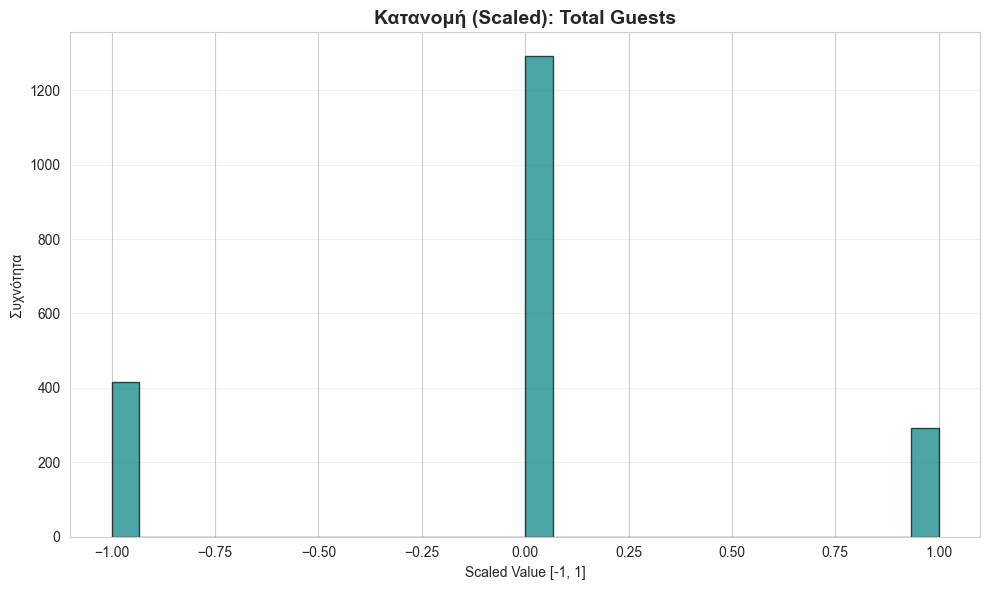

In [698]:
# Ιστόγραμμα για Total_Guests (scaled)
plt.figure(figsize=(10, 6))
plt.hist(df_scaled['Total_Guests'], bins=30, edgecolor='black', alpha=0.7, color='teal')
plt.title('Κατανομή (Scaled): Total Guests', fontsize=14, fontweight='bold')
plt.xlabel('Scaled Value [-1, 1]')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

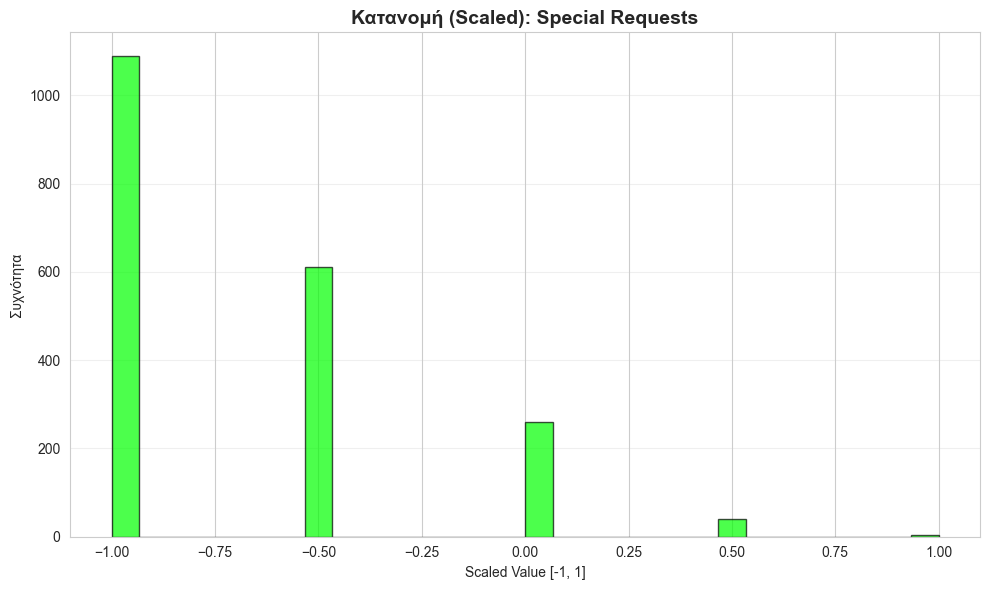

In [699]:
# Ιστόγραμμα για special.requests (scaled)
plt.figure(figsize=(10, 6))
plt.hist(df_scaled['special.requests'], bins=30, edgecolor='black', alpha=0.7, color='lime')
plt.title('Κατανομή (Scaled): Special Requests', fontsize=14, fontweight='bold')
plt.xlabel('Scaled Value [-1, 1]')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

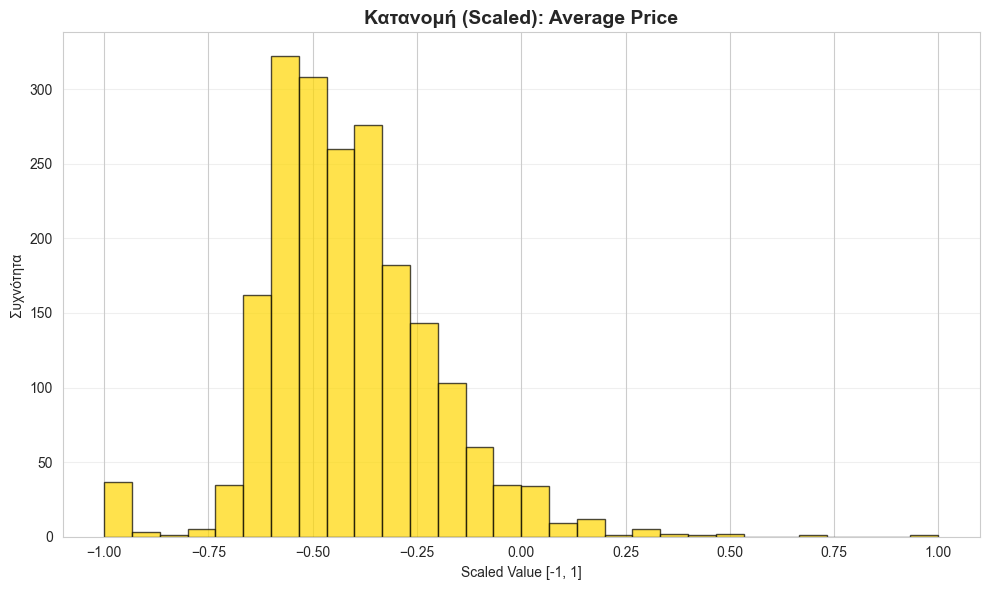

In [700]:
# Ιστόγραμμα για average.price (scaled)
plt.figure(figsize=(10, 6))
plt.hist(df_scaled['average.price'], bins=30, edgecolor='black', alpha=0.7, color='gold')
plt.title('Κατανομή (Scaled): Average Price', fontsize=14, fontweight='bold')
plt.xlabel('Scaled Value [-1, 1]')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

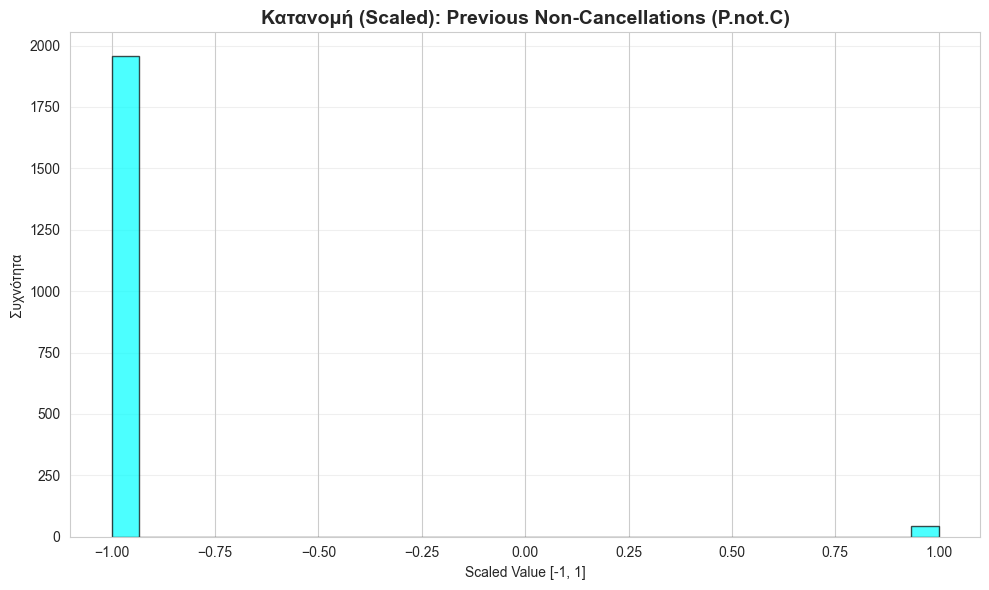

In [701]:
# Ιστόγραμμα για P.not.C (scaled)
plt.figure(figsize=(10, 6))
plt.hist(df_scaled['P.not.C'], bins=30, edgecolor='black', alpha=0.7, color='cyan')
plt.title('Κατανομή (Scaled): Previous Non-Cancellations (P.not.C)', fontsize=14, fontweight='bold')
plt.xlabel('Scaled Value [-1, 1]')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

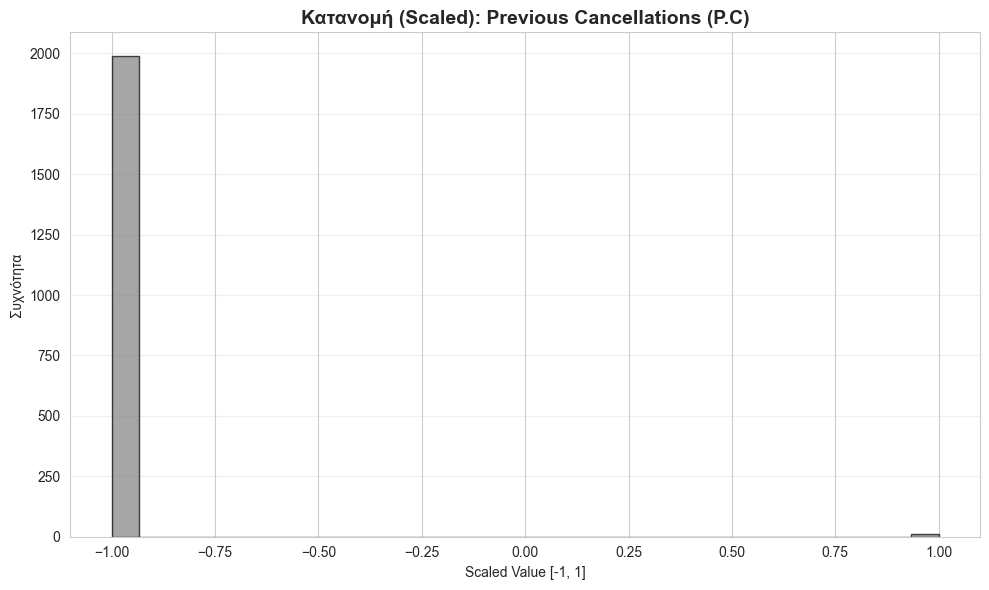

In [702]:
# Ιστόγραμμα για P.C (scaled)
plt.figure(figsize=(10, 6))
plt.hist(df_scaled['P.C'], bins=30, edgecolor='black', alpha=0.7, color='gray')
plt.title('Κατανομή (Scaled): Previous Cancellations (P.C)', fontsize=14, fontweight='bold')
plt.xlabel('Scaled Value [-1, 1]')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

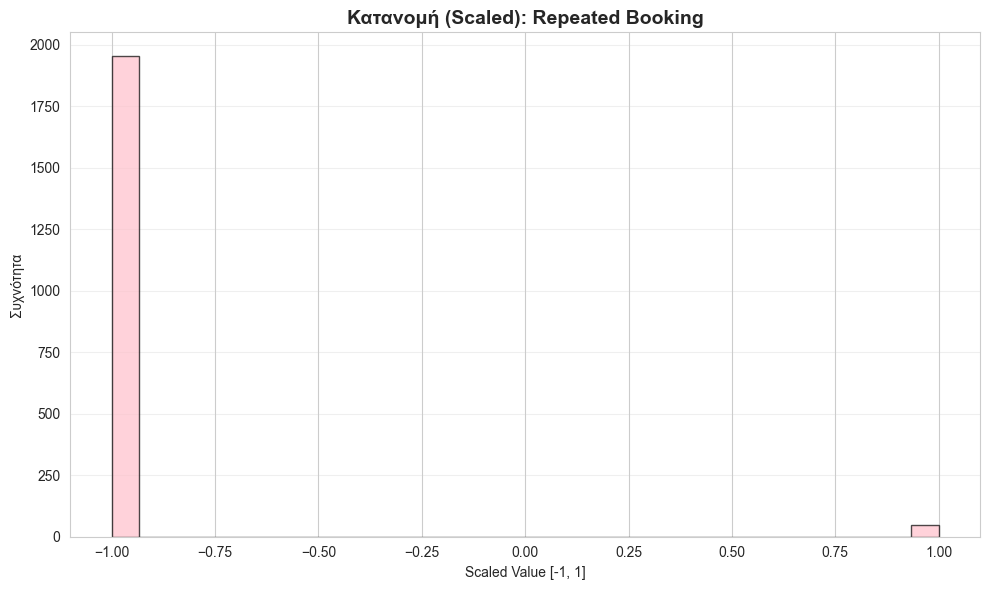

In [703]:
# Ιστόγραμμα για repeated (scaled)
plt.figure(figsize=(10, 6))
plt.hist(df_scaled['repeated'], bins=30, edgecolor='black', alpha=0.7, color='pink')
plt.title('Κατανομή (Scaled): Repeated Booking', fontsize=14, fontweight='bold')
plt.xlabel('Scaled Value [-1, 1]')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

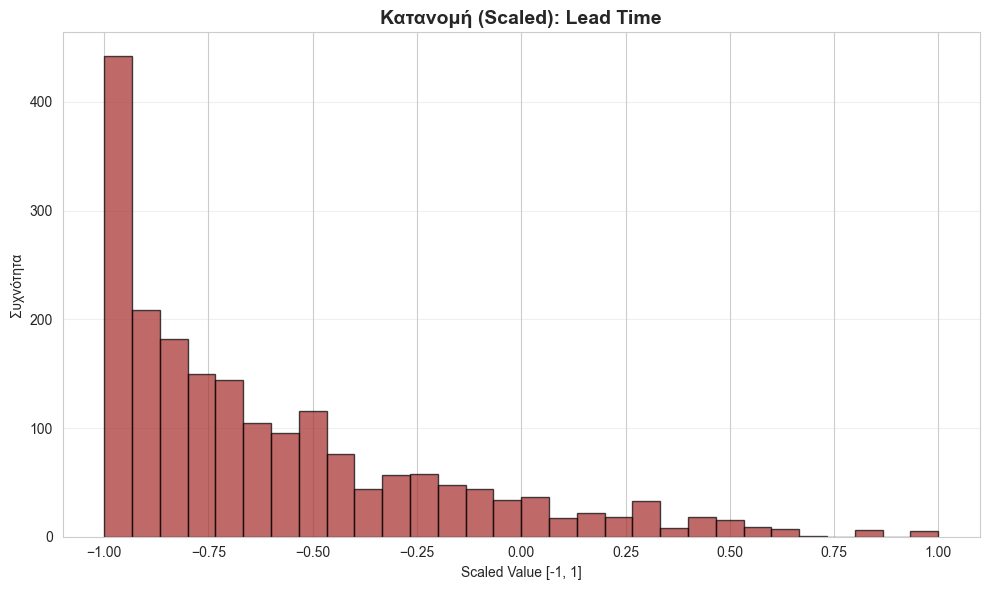

In [704]:
# Ιστόγραμμα για lead.time (scaled)
plt.figure(figsize=(10, 6))
plt.hist(df_scaled['lead.time'], bins=30, edgecolor='black', alpha=0.7, color='brown')
plt.title('Κατανομή (Scaled): Lead Time', fontsize=14, fontweight='bold')
plt.xlabel('Scaled Value [-1, 1]')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

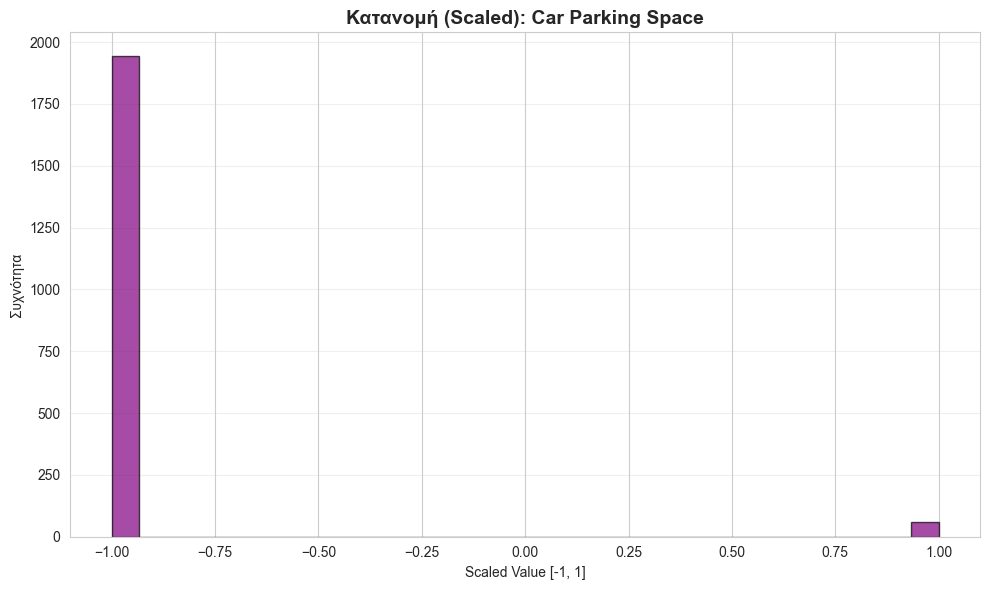

In [705]:
# Ιστόγραμμα για car.parking.space (scaled)
plt.figure(figsize=(10, 6))
plt.hist(df_scaled['car.parking.space'], bins=30, edgecolor='black', alpha=0.7, color='purple')
plt.title('Κατανομή (Scaled): Car Parking Space', fontsize=14, fontweight='bold')
plt.xlabel('Scaled Value [-1, 1]')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

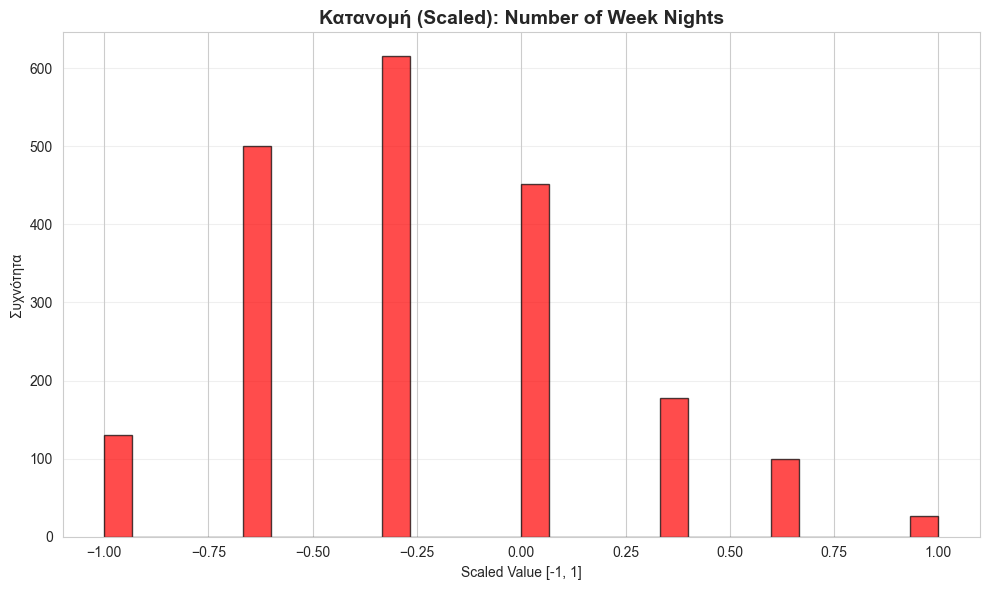

In [706]:
# Ιστόγραμμα για number.of.week.nights (scaled)
plt.figure(figsize=(10, 6))
plt.hist(df_scaled['number.of.week.nights'], bins=30, edgecolor='black', alpha=0.7, color='red')
plt.title('Κατανομή (Scaled): Number of Week Nights', fontsize=14, fontweight='bold')
plt.xlabel('Scaled Value [-1, 1]')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

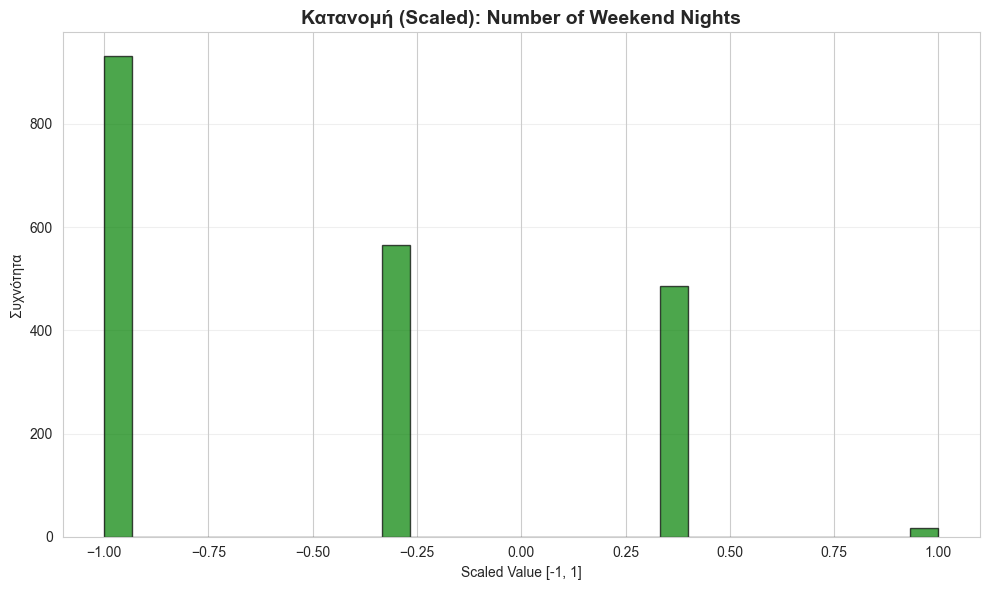

In [707]:
# Ιστόγραμμα για number.of.weekend.nights (scaled)
plt.figure(figsize=(10, 6))
plt.hist(df_scaled['number.of.weekend.nights'], bins=30, edgecolor='black', alpha=0.7, color='green')
plt.title('Κατανομή (Scaled): Number of Weekend Nights', fontsize=14, fontweight='bold')
plt.xlabel('Scaled Value [-1, 1]')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

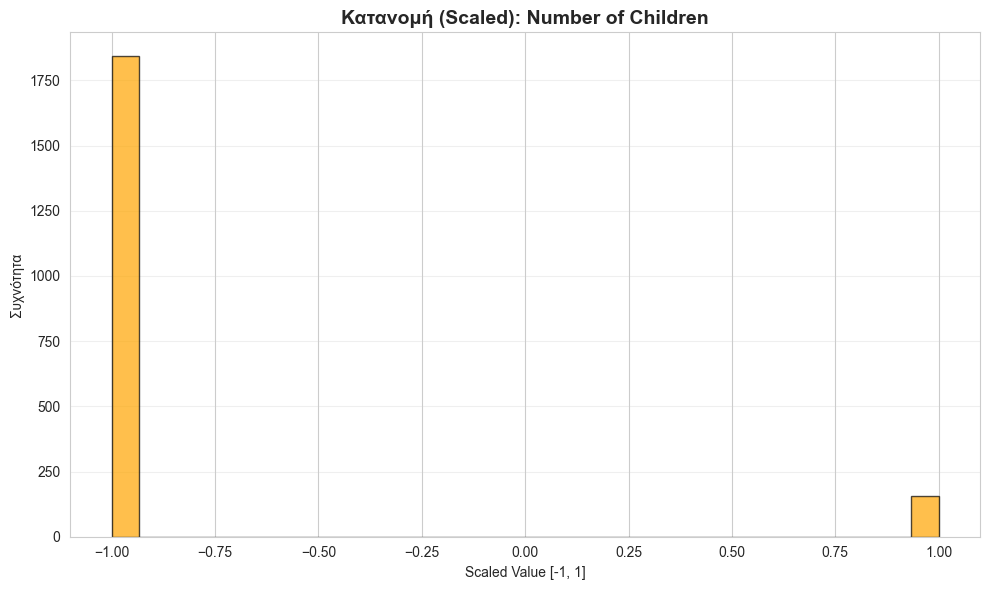

In [708]:
# Ιστόγραμμα για number.of.children (scaled)
plt.figure(figsize=(10, 6))
plt.hist(df_scaled['number.of.children'], bins=30, edgecolor='black', alpha=0.7, color='orange')
plt.title('Κατανομή (Scaled): Number of Children', fontsize=14, fontweight='bold')
plt.xlabel('Scaled Value [-1, 1]')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

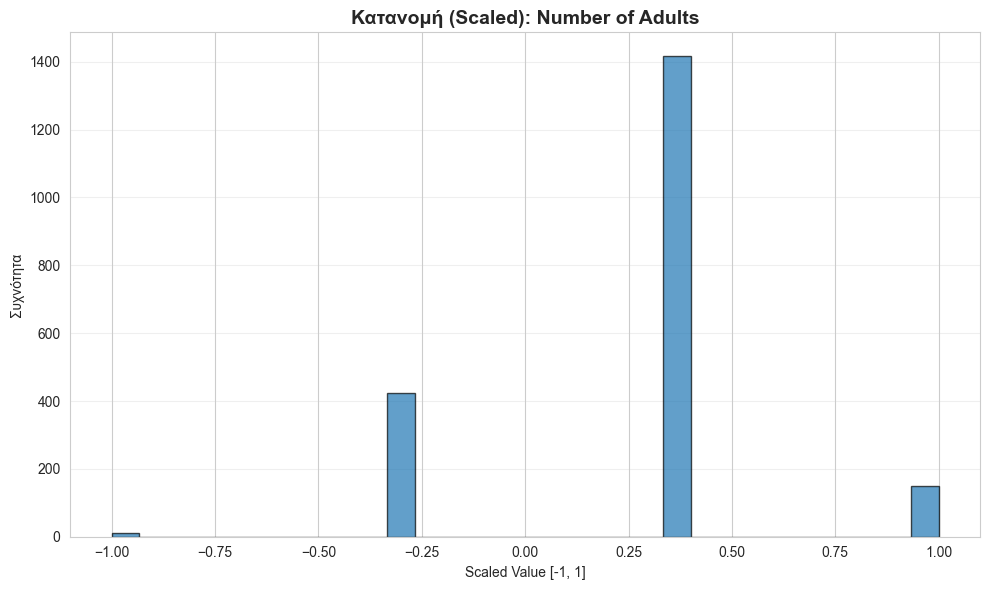

In [709]:
# Ιστόγραμμα για number.of.adults (scaled)
plt.figure(figsize=(10, 6))
plt.hist(df_scaled['number.of.adults'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Κατανομή (Scaled): Number of Adults', fontsize=14, fontweight='bold')
plt.xlabel('Scaled Value [-1, 1]')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 5.2 Ιστογράμματα Scaled Δεδομένων

Οπτικοποίηση των κανονικοποιημένων μεταβλητών στο εύρος [-1, 1].

## 5.1 Scaling Δεδομένων στο [-1, 1]

Εφαρμογή MinMaxScaler για κανονικοποίηση όλων των features στο εύρος [-1, 1].

## 6. Αποθήκευση Επεξεργασμένων Δεδομένων

In [710]:
# Αποθήκευση
df_encoded.to_csv('processed_data.csv', index=False)
print("Τα επεξεργασμένα δεδομένα αποθηκεύτηκαν στο 'processed_data.csv'")

Τα επεξεργασμένα δεδομένα αποθηκεύτηκαν στο 'processed_data.csv'


## 7. Ιστογράμματα για Κάθε Μεταβλητή

Δημιουργία ιστογραμμάτων για όλες τις αριθμητικές μεταβλητές (ένα plot ανά figure).

In [711]:
# Επιλογή μόνο των αριθμητικών μεταβλητών (χωρίς τις one-hot encoded)
numeric_columns = df_processed.select_dtypes(include=[np.number]).columns.tolist()

print(f"Αριθμητικές μεταβλητές: {len(numeric_columns)}")
print(numeric_columns)

Αριθμητικές μεταβλητές: 18
['number.of.adults', 'number.of.children', 'number.of.weekend.nights', 'number.of.week.nights', 'car.parking.space', 'lead.time', 'repeated', 'P.C', 'P.not.C', 'average.price', 'special.requests', 'Total_Guests', 'Is_Family', 'Total_Nights', 'Cancellation_Ratio', 'Price_per_Person', 'Arrival_Month', 'Off_Season']


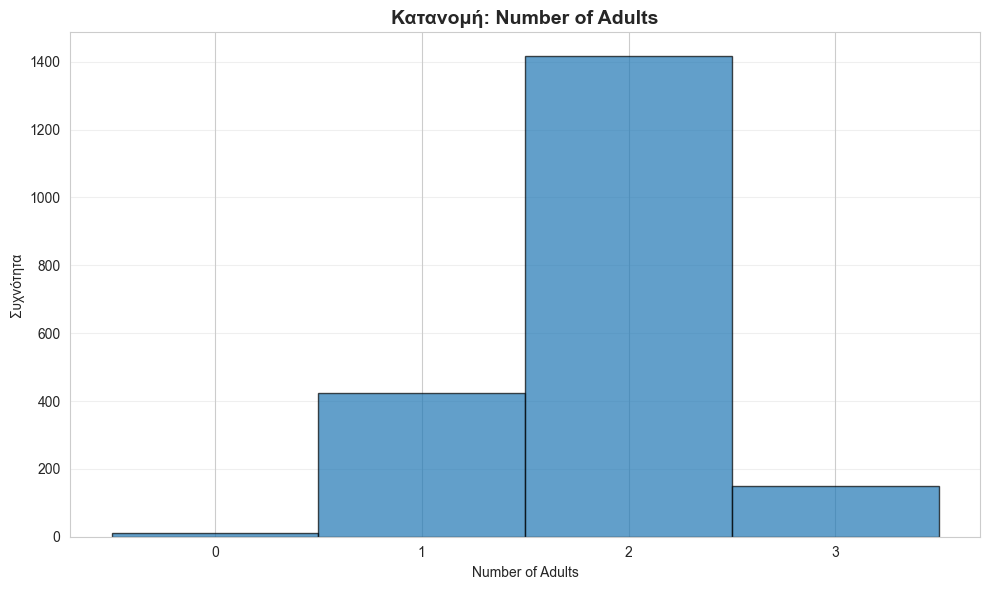

In [712]:
# Ιστόγραμμα για number.of.adults
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['number.of.adults'].unique())
bins = [x - 0.5 for x in range(int(df_processed['number.of.adults'].max()) + 2)]
plt.hist(df_processed['number.of.adults'], bins=bins, edgecolor='black', alpha=0.7, align='mid')
plt.title('Κατανομή: Number of Adults', fontsize=14, fontweight='bold')
plt.xlabel('Number of Adults')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

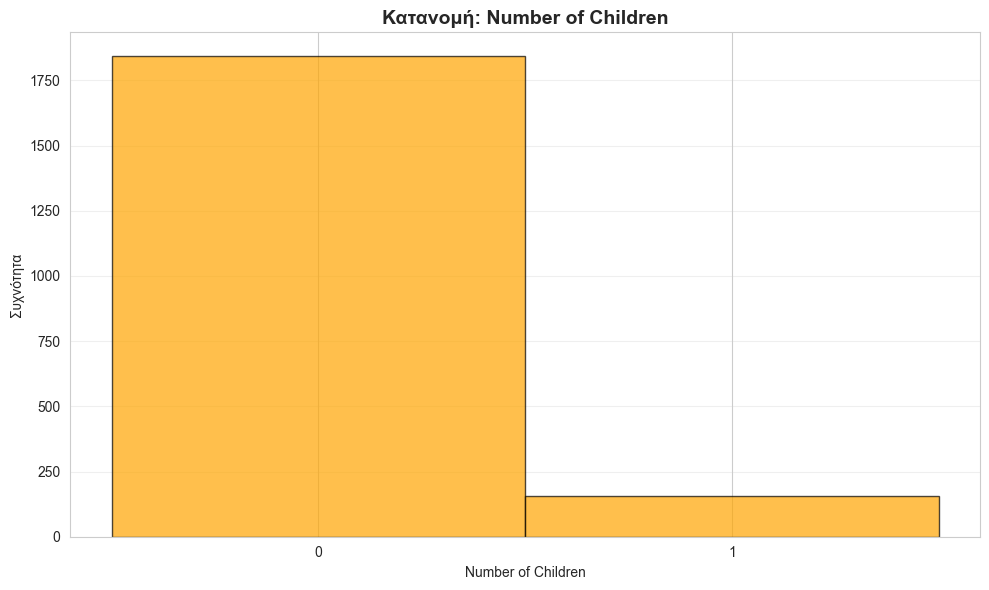

In [713]:
# Ιστόγραμμα για number.of.children
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['number.of.children'].unique())
bins = [x - 0.5 for x in range(int(df_processed['number.of.children'].max()) + 2)]
plt.hist(df_processed['number.of.children'], bins=bins, edgecolor='black', alpha=0.7, color='orange', align='mid')
plt.title('Κατανομή: Number of Children', fontsize=14, fontweight='bold')
plt.xlabel('Number of Children')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

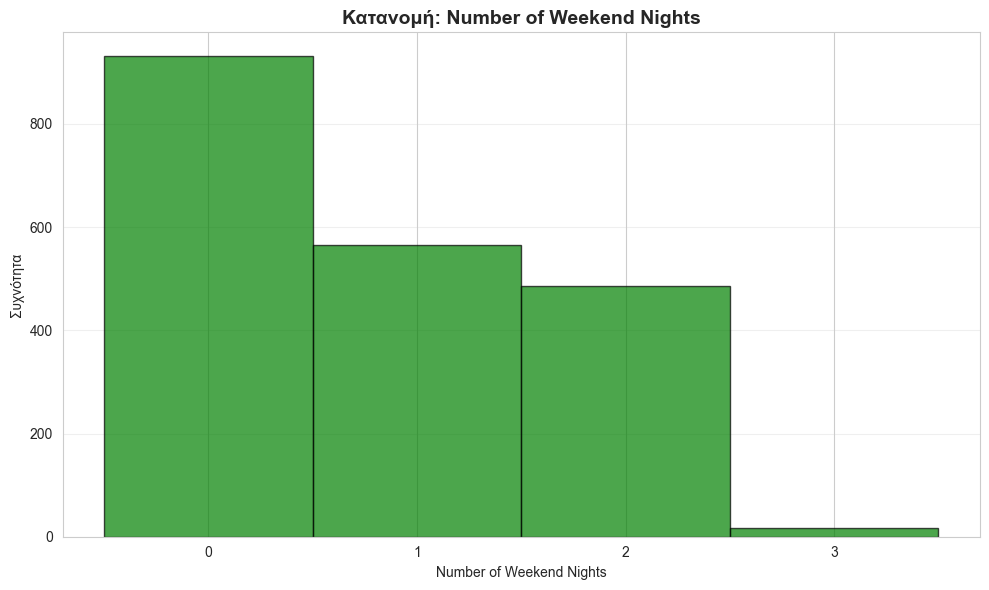

In [714]:
# Ιστόγραμμα για number.of.weekend.nights
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['number.of.weekend.nights'].unique())
bins = [x - 0.5 for x in range(int(df_processed['number.of.weekend.nights'].max()) + 2)]
plt.hist(df_processed['number.of.weekend.nights'], bins=bins, edgecolor='black', alpha=0.7, color='green', align='mid')
plt.title('Κατανομή: Number of Weekend Nights', fontsize=14, fontweight='bold')
plt.xlabel('Number of Weekend Nights')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

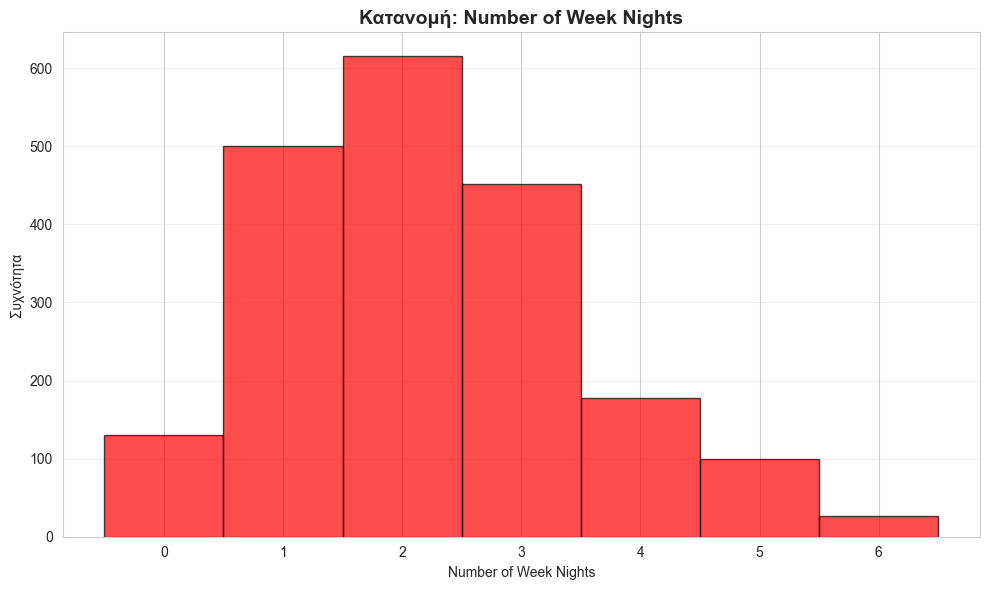

In [715]:
# Ιστόγραμμα για number.of.week.nights
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['number.of.week.nights'].unique())
bins = [x - 0.5 for x in range(int(df_processed['number.of.week.nights'].max()) + 2)]
plt.hist(df_processed['number.of.week.nights'], bins=bins, edgecolor='black', alpha=0.7, color='red', align='mid')
plt.title('Κατανομή: Number of Week Nights', fontsize=14, fontweight='bold')
plt.xlabel('Number of Week Nights')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

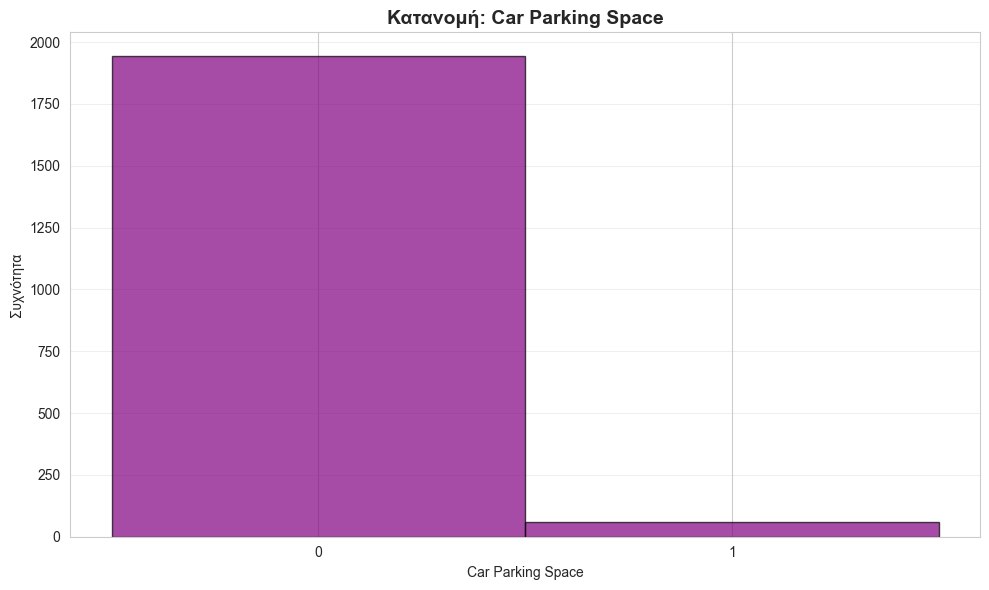

In [716]:
# Ιστόγραμμα για car.parking.space
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['car.parking.space'].unique())
bins = [x - 0.5 for x in range(int(df_processed['car.parking.space'].max()) + 2)]
plt.hist(df_processed['car.parking.space'], bins=bins, edgecolor='black', alpha=0.7, color='purple', align='mid')
plt.title('Κατανομή: Car Parking Space', fontsize=14, fontweight='bold')
plt.xlabel('Car Parking Space')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

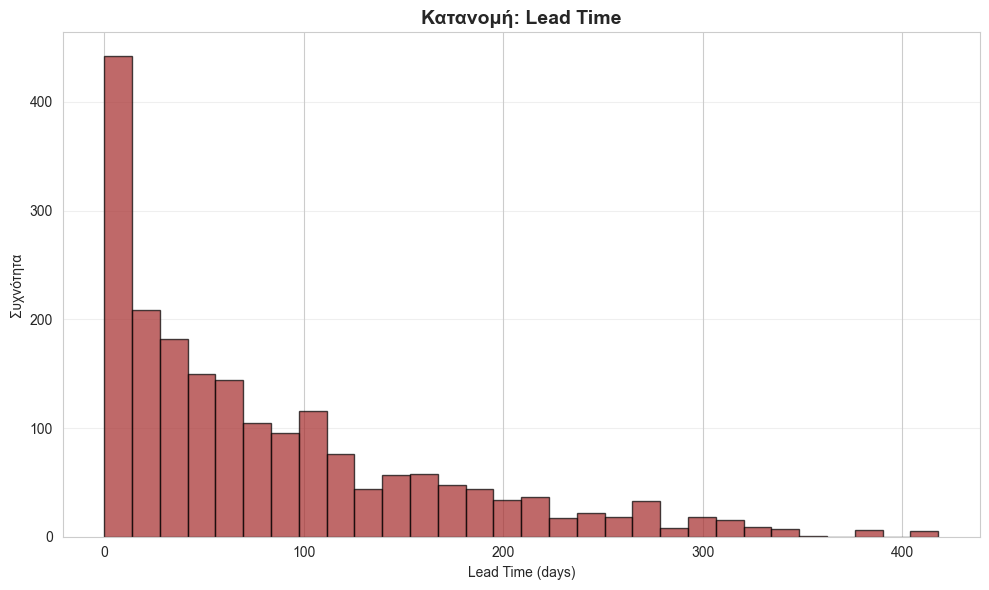

In [717]:
# Ιστόγραμμα για lead.time
plt.figure(figsize=(10, 6))
plt.hist(df_processed['lead.time'], bins=30, edgecolor='black', alpha=0.7, color='brown')
plt.title('Κατανομή: Lead Time', fontsize=14, fontweight='bold')
plt.xlabel('Lead Time (days)')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

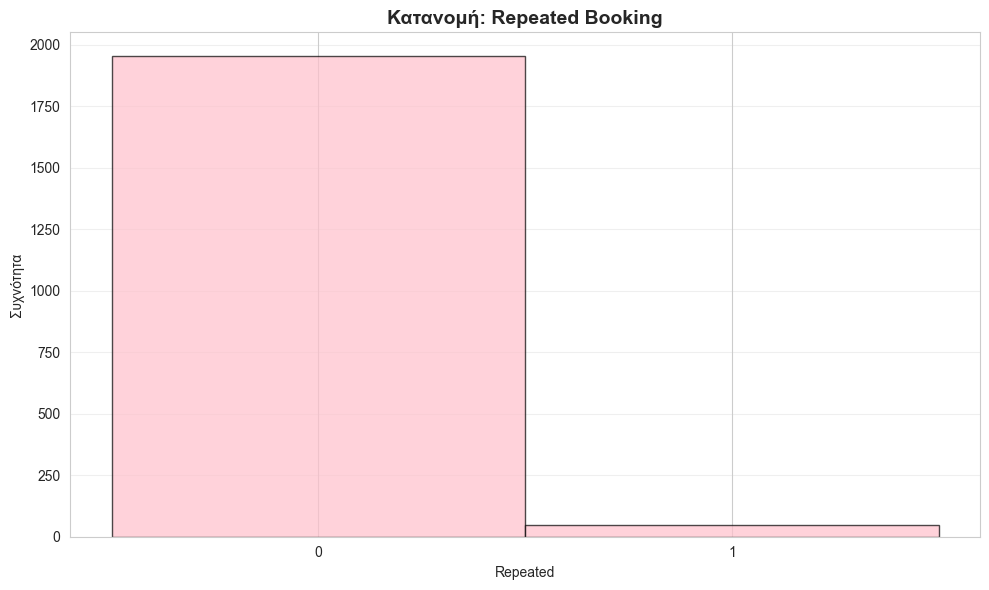

In [718]:
# Ιστόγραμμα για repeated
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['repeated'].unique())
bins = [x - 0.5 for x in range(int(df_processed['repeated'].max()) + 2)]
plt.hist(df_processed['repeated'], bins=bins, edgecolor='black', alpha=0.7, color='pink', align='mid')
plt.title('Κατανομή: Repeated Booking', fontsize=14, fontweight='bold')
plt.xlabel('Repeated')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

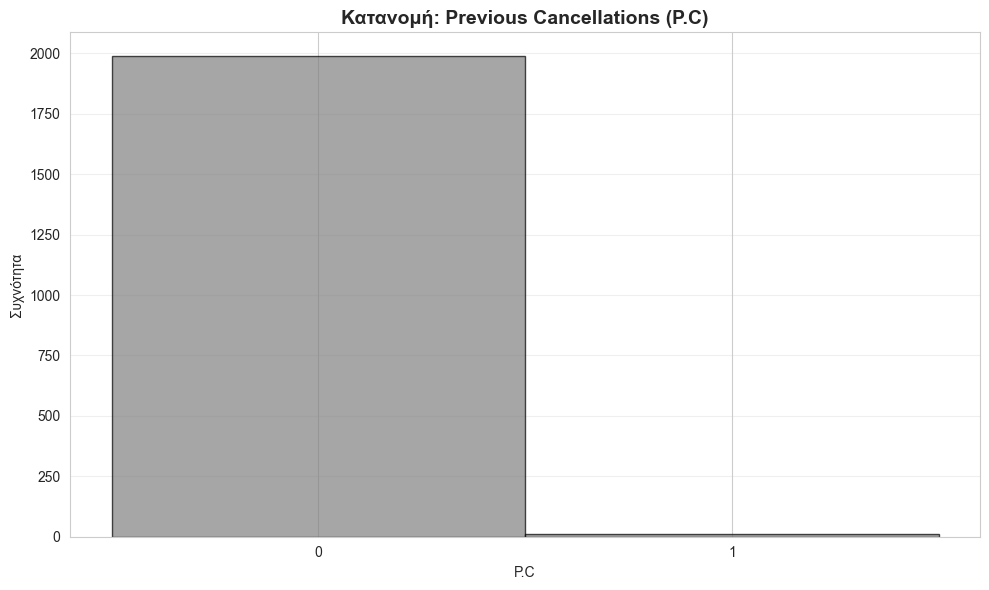

In [719]:
# Ιστόγραμμα για P.C
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['P.C'].unique())
bins = [x - 0.5 for x in range(int(df_processed['P.C'].max()) + 2)]
plt.hist(df_processed['P.C'], bins=bins, edgecolor='black', alpha=0.7, color='gray', align='mid')
plt.title('Κατανομή: Previous Cancellations (P.C)', fontsize=14, fontweight='bold')
plt.xlabel('P.C')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

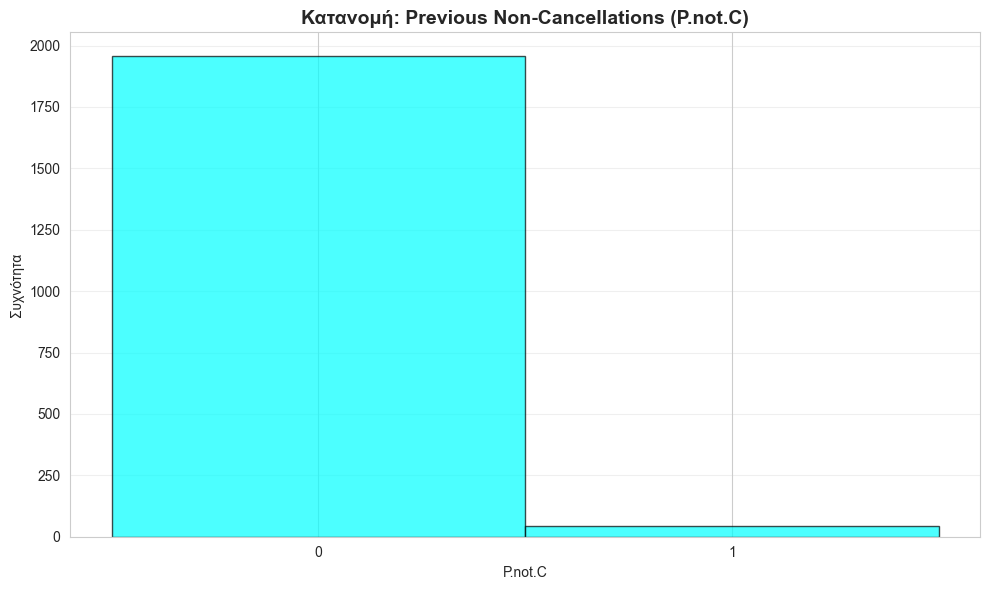

In [720]:
# Ιστόγραμμα για P.not.C
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['P.not.C'].unique())
bins = [x - 0.5 for x in range(int(df_processed['P.not.C'].max()) + 2)]
plt.hist(df_processed['P.not.C'], bins=bins, edgecolor='black', alpha=0.7, color='cyan', align='mid')
plt.title('Κατανομή: Previous Non-Cancellations (P.not.C)', fontsize=14, fontweight='bold')
plt.xlabel('P.not.C')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

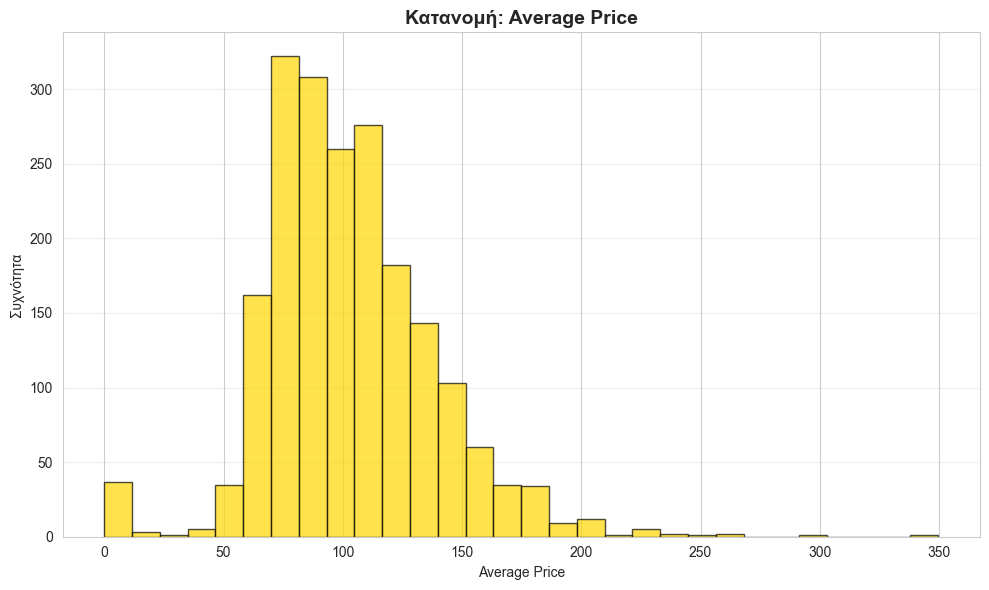

In [721]:
# Ιστόγραμμα για average.price
plt.figure(figsize=(10, 6))
plt.hist(df_processed['average.price'], bins=30, edgecolor='black', alpha=0.7, color='gold')
plt.title('Κατανομή: Average Price', fontsize=14, fontweight='bold')
plt.xlabel('Average Price')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

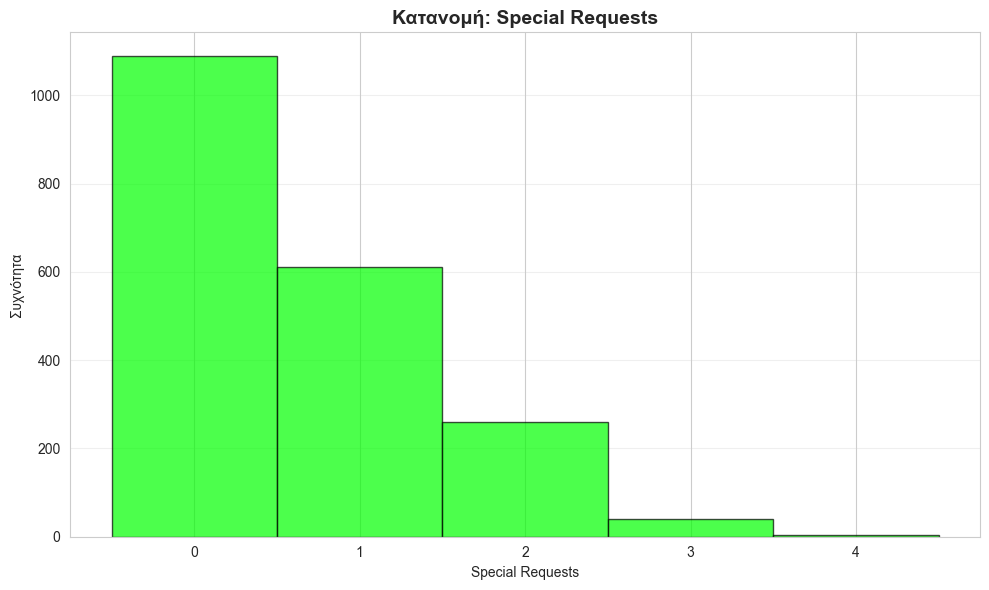

In [722]:
# Ιστόγραμμα για special.requests
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['special.requests'].unique())
bins = [x - 0.5 for x in range(int(df_processed['special.requests'].max()) + 2)]
plt.hist(df_processed['special.requests'], bins=bins, edgecolor='black', alpha=0.7, color='lime', align='mid')
plt.title('Κατανομή: Special Requests', fontsize=14, fontweight='bold')
plt.xlabel('Special Requests')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

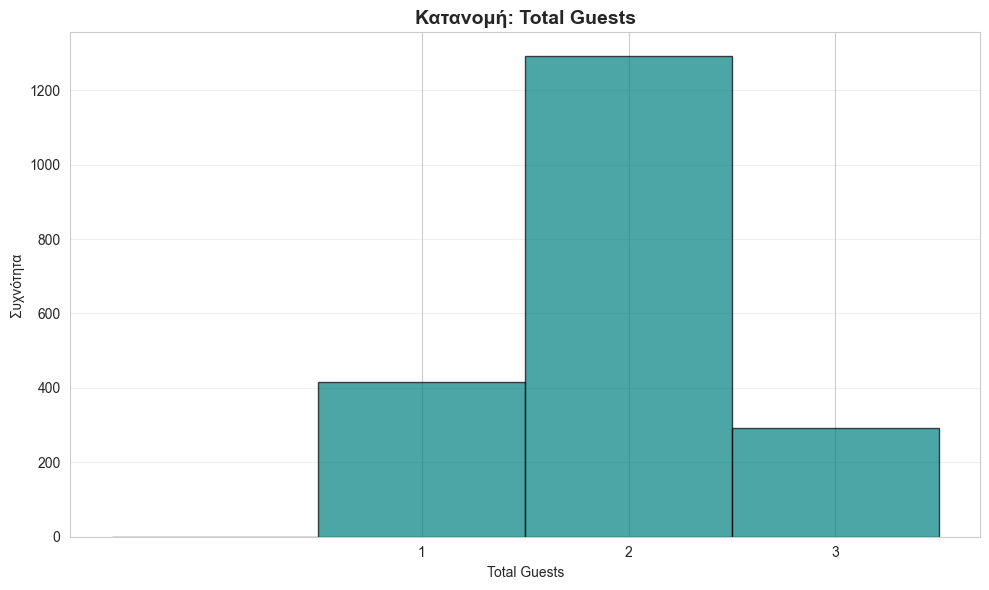

In [723]:
# Ιστόγραμμα για Total_Guests
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['Total_Guests'].unique())
bins = [x - 0.5 for x in range(int(df_processed['Total_Guests'].max()) + 2)]
plt.hist(df_processed['Total_Guests'], bins=bins, edgecolor='black', alpha=0.7, color='teal', align='mid')
plt.title('Κατανομή: Total Guests', fontsize=14, fontweight='bold')
plt.xlabel('Total Guests')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

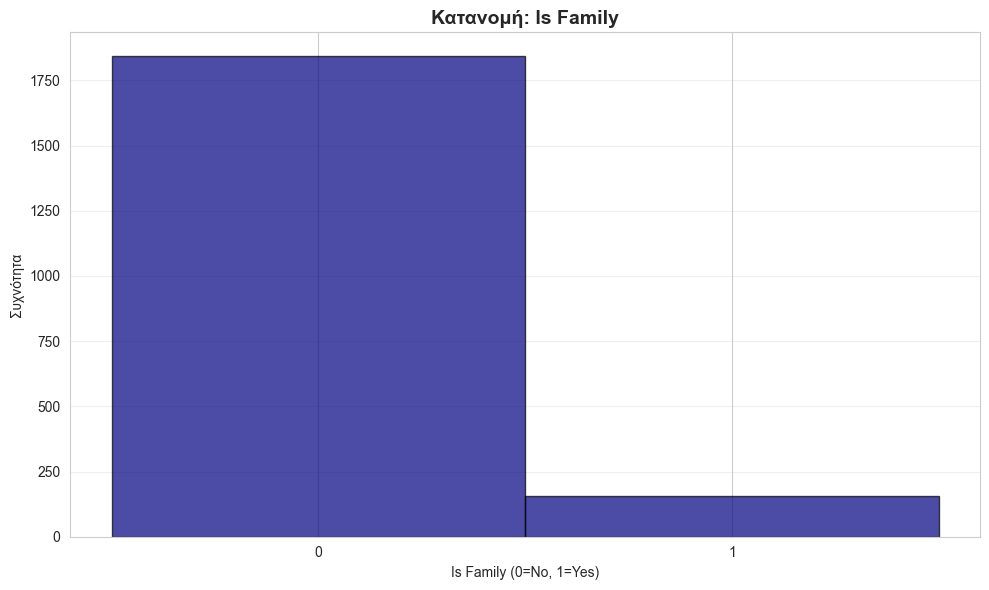

In [724]:
# Ιστόγραμμα για Is_Family
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['Is_Family'].unique())
bins = [x - 0.5 for x in range(int(df_processed['Is_Family'].max()) + 2)]
plt.hist(df_processed['Is_Family'], bins=bins, edgecolor='black', alpha=0.7, color='navy', align='mid')
plt.title('Κατανομή: Is Family', fontsize=14, fontweight='bold')
plt.xlabel('Is Family (0=No, 1=Yes)')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)

plt.grid(axis='y', alpha=0.3)   
plt.tight_layout()
plt.show()

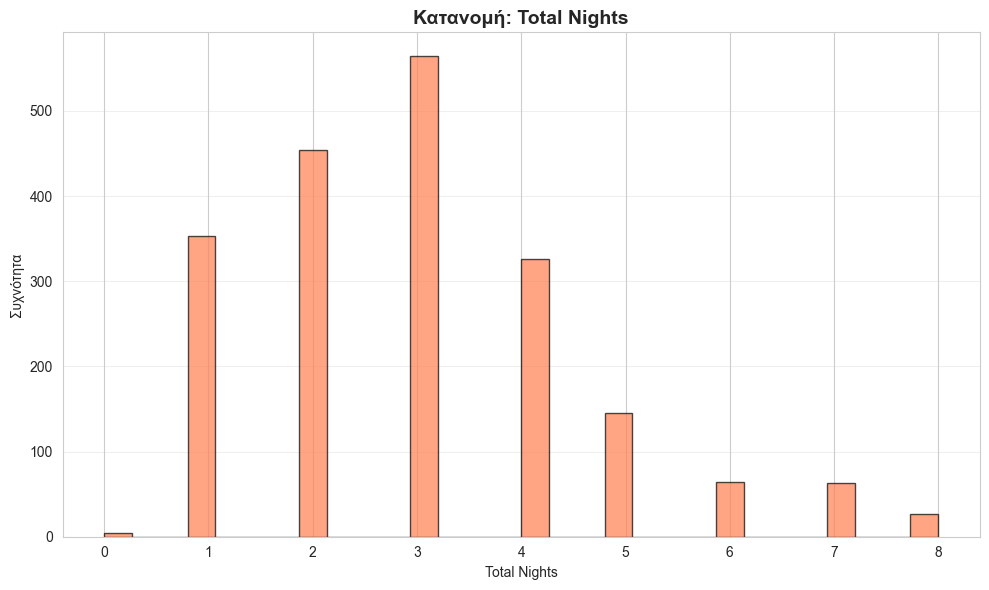

In [725]:
# Ιστόγραμμα για Total_Nights
plt.figure(figsize=(10, 6))
plt.hist(df_processed['Total_Nights'], bins=30, edgecolor='black', alpha=0.7, color='coral')
plt.title('Κατανομή: Total Nights', fontsize=14, fontweight='bold')
plt.xlabel('Total Nights')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

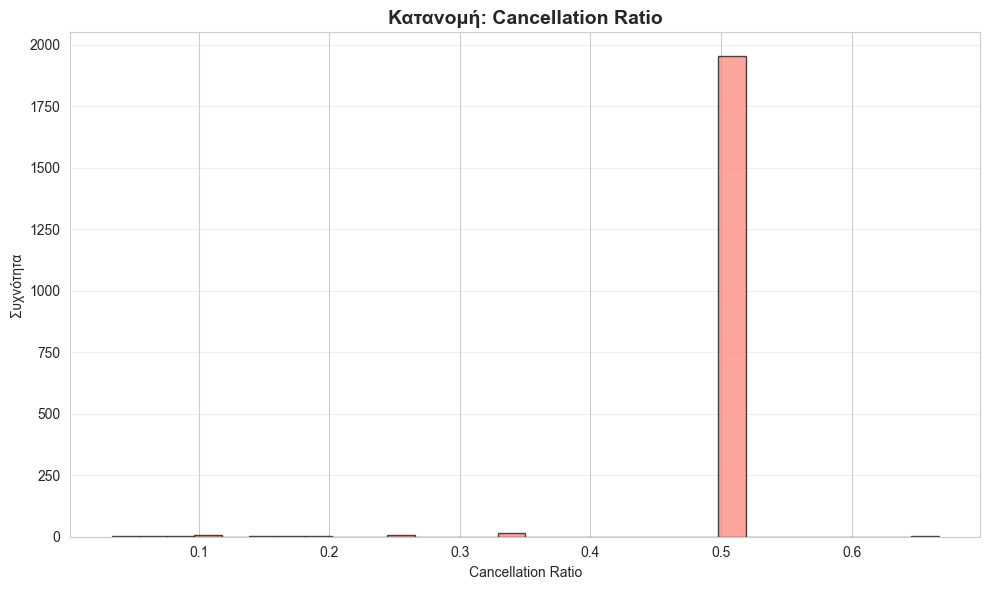

In [726]:
# Ιστόγραμμα για Cancellation_Ratio
plt.figure(figsize=(10, 6))
plt.hist(df_processed['Cancellation_Ratio'], bins=30, edgecolor='black', alpha=0.7, color='salmon')
plt.title('Κατανομή: Cancellation Ratio', fontsize=14, fontweight='bold')
plt.xlabel('Cancellation Ratio')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

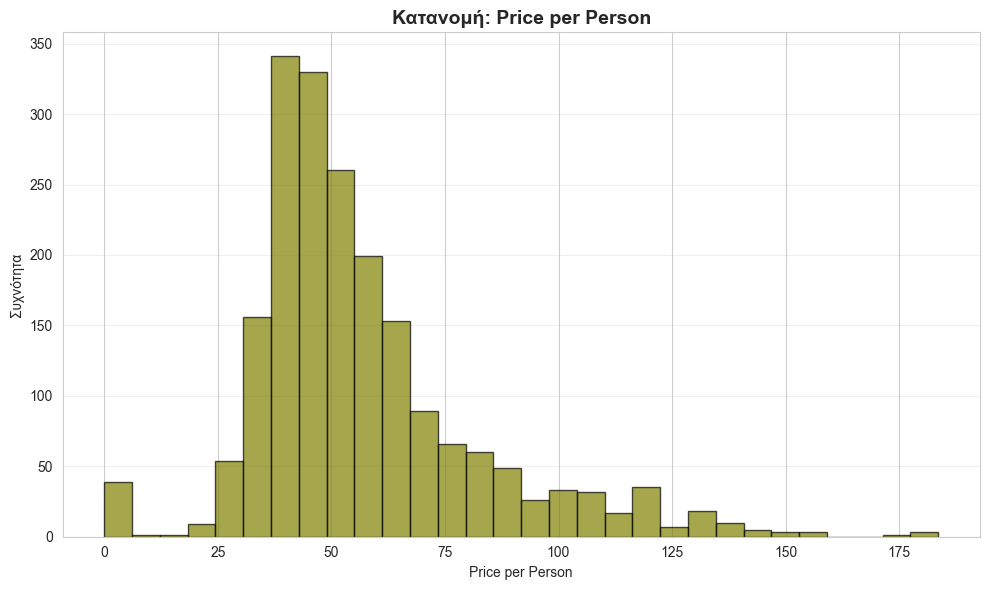

In [727]:
# Ιστόγραμμα για Price_per_Person
plt.figure(figsize=(10, 6))
plt.hist(df_processed['Price_per_Person'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='olive')
plt.title('Κατανομή: Price per Person', fontsize=14, fontweight='bold')
plt.xlabel('Price per Person')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

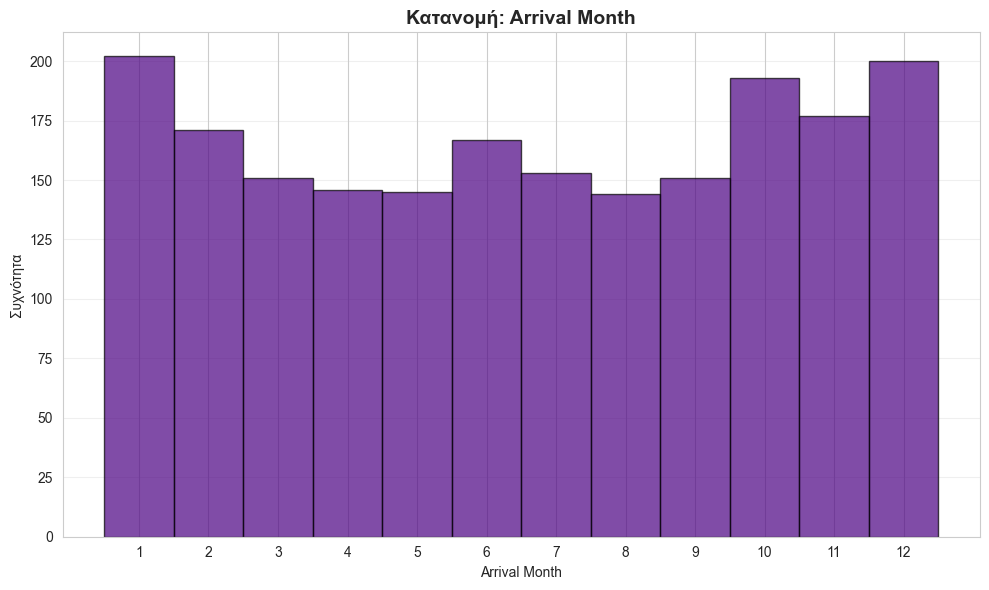

In [728]:
# Ιστόγραμμα για Arrival_Month
plt.figure(figsize=(10, 6))
bins = [x - 0.5 for x in range(1, 14)]  # Μήνες από 1 έως 12
plt.hist(df_processed['Arrival_Month'], bins=bins, edgecolor='black', alpha=0.7, color='indigo', align='mid')
plt.title('Κατανομή: Arrival Month', fontsize=14, fontweight='bold')
plt.xlabel('Arrival Month')
plt.ylabel('Συχνότητα')
plt.xticks(range(1, 13))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Clustering Analysis

Εφαρμογή K-Means και Hierarchical Clustering με αξιολόγηση μέσω διαφόρων μετρικών.

In [729]:
# Βιβλιοθήκες για clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

print("Βιβλιοθήκες clustering φορτώθηκαν επιτυχώς!")

Βιβλιοθήκες clustering φορτώθηκαν επιτυχώς!


### 8.1 K-Means Clustering

In [730]:
# Προετοιμασία δεδομένων για clustering (χρήση scaled δεδομένων)
X = df_scaled.values

# Εύρος k
k_range = range(2, 11)

# Αποθήκευση μετρικών
kmeans_inertia = []
kmeans_silhouette = []
kmeans_labels_dict = {}

print("Εκτέλεση K-Means για k = 2 έως 10...")
for k in k_range:
    print(f"K-Means με k={k}...", end=" ")
    
    # K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    # Αποθήκευση labels
    kmeans_labels_dict[k] = labels
    
    # Inertia
    kmeans_inertia.append(kmeans.inertia_)
    
    # Silhouette Score
    silhouette = silhouette_score(X, labels)
    kmeans_silhouette.append(silhouette)
    
    print(f"✓ (Inertia: {kmeans.inertia_:.2f}, Silhouette: {silhouette:.4f})")

print("\nK-Means ολοκληρώθηκε!")

Εκτέλεση K-Means για k = 2 έως 10...
K-Means με k=2... ✓ (Inertia: 8419.86, Silhouette: 0.3079)
K-Means με k=3... ✓ (Inertia: 7216.36, Silhouette: 0.2561)
K-Means με k=4... ✓ (Inertia: 6124.31, Silhouette: 0.3017)
K-Means με k=5... ✓ (Inertia: 5226.06, Silhouette: 0.3188)
K-Means με k=6... ✓ (Inertia: 4684.94, Silhouette: 0.3150)
K-Means με k=7... ✓ (Inertia: 6124.31, Silhouette: 0.3017)
K-Means με k=5... ✓ (Inertia: 5226.06, Silhouette: 0.3188)
K-Means με k=6... ✓ (Inertia: 4684.94, Silhouette: 0.3150)
K-Means με k=7... ✓ (Inertia: 4362.58, Silhouette: 0.2771)
K-Means με k=8... ✓ (Inertia: 4196.09, Silhouette: 0.2536)
K-Means με k=9... ✓ (Inertia: 3938.07, Silhouette: 0.2621)
K-Means με k=10... ✓ (Inertia: 4362.58, Silhouette: 0.2771)
K-Means με k=8... ✓ (Inertia: 4196.09, Silhouette: 0.2536)
K-Means με k=9... ✓ (Inertia: 3938.07, Silhouette: 0.2621)
K-Means με k=10... ✓ (Inertia: 3806.55, Silhouette: 0.2440)

K-Means ολοκληρώθηκε!
✓ (Inertia: 3806.55, Silhouette: 0.2440)

K-Means ολο

### 8.2 Hierarchical Clustering

In [731]:
# Αποθήκευση μετρικών για Hierarchical
hierarchical_silhouette = []
hierarchical_labels_dict = {}

print("Εκτέλεση Hierarchical Clustering για k = 2 έως 10...")
for k in k_range:
    print(f"Hierarchical με k={k}...", end=" ")
    
    # Hierarchical Clustering
    hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = hierarchical.fit_predict(X)
    
    # Αποθήκευση labels
    hierarchical_labels_dict[k] = labels
    
    # Silhouette Score
    silhouette = silhouette_score(X, labels)
    hierarchical_silhouette.append(silhouette)
    
    print(f"✓ (Silhouette: {silhouette:.4f})")

print("\nHierarchical Clustering ολοκληρώθηκε!")

Εκτέλεση Hierarchical Clustering για k = 2 έως 10...
Hierarchical με k=2... ✓ (Silhouette: 0.3053)
Hierarchical με k=3... ✓ (Silhouette: 0.3322)
Hierarchical με k=4... ✓ (Silhouette: 0.2729)
Hierarchical με k=5... ✓ (Silhouette: 0.3322)
Hierarchical με k=4... ✓ (Silhouette: 0.2729)
Hierarchical με k=5... ✓ (Silhouette: 0.3128)
Hierarchical με k=6... ✓ (Silhouette: 0.3077)
Hierarchical με k=7... ✓ (Silhouette: 0.3128)
Hierarchical με k=6... ✓ (Silhouette: 0.3077)
Hierarchical με k=7... ✓ (Silhouette: 0.2743)
Hierarchical με k=8... ✓ (Silhouette: 0.2807)
Hierarchical με k=9... ✓ (Silhouette: 0.2743)
Hierarchical με k=8... ✓ (Silhouette: 0.2807)
Hierarchical με k=9... ✓ (Silhouette: 0.2771)
Hierarchical με k=10... ✓ (Silhouette: 0.2844)

Hierarchical Clustering ολοκληρώθηκε!
✓ (Silhouette: 0.2771)
Hierarchical με k=10... ✓ (Silhouette: 0.2844)

Hierarchical Clustering ολοκληρώθηκε!


### 8.3 Υπολογισμός NMI και ARI

Σύγκριση K-Means και Hierarchical Clustering με NMI (Normalized Mutual Information) και ARI (Adjusted Rand Index).

In [732]:
# Υπολογισμός NMI και ARI μεταξύ K-Means και Hierarchical
nmi_scores = []
ari_scores = []

print("Υπολογισμός NMI και ARI μεταξύ K-Means και Hierarchical...")
for k in k_range:
    kmeans_labels = kmeans_labels_dict[k]
    hierarchical_labels = hierarchical_labels_dict[k]
    
    # NMI
    nmi = normalized_mutual_info_score(kmeans_labels, hierarchical_labels)
    nmi_scores.append(nmi)
    
    # ARI
    ari = adjusted_rand_score(kmeans_labels, hierarchical_labels)
    ari_scores.append(ari)
    
    print(f"k={k}: NMI={nmi:.4f}, ARI={ari:.4f}")

print("\nΥπολογισμοί ολοκληρώθηκαν!")

Υπολογισμός NMI και ARI μεταξύ K-Means και Hierarchical...
k=2: NMI=0.9587, ARI=0.9820
k=3: NMI=0.6328, ARI=0.5877
k=4: NMI=0.7976, ARI=0.7845
k=5: NMI=0.9613, ARI=0.9734
k=6: NMI=0.9613, ARI=0.9717
k=7: NMI=0.8733, ARI=0.8213
k=8: NMI=0.8417, ARI=0.7607
k=9: NMI=0.8400, ARI=0.7470
k=10: NMI=0.8221, ARI=0.7280

Υπολογισμοί ολοκληρώθηκαν!


### 8.4 Οπτικοποίηση Αποτελεσμάτων

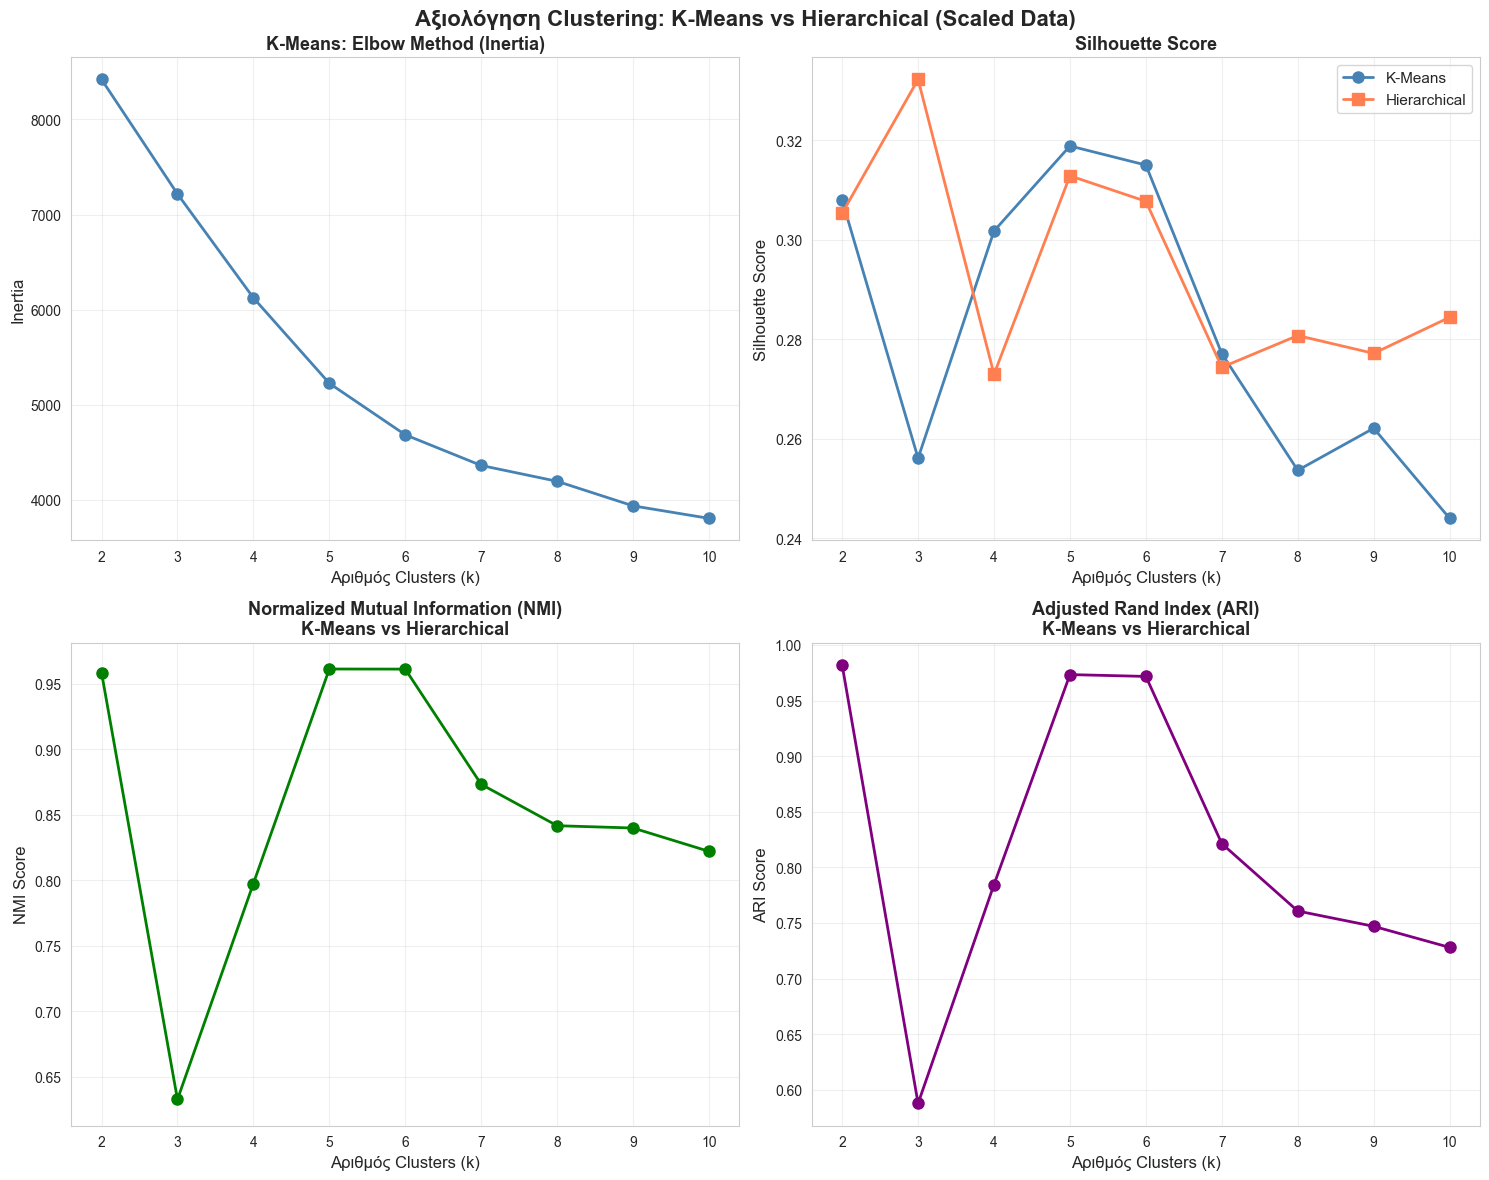


ΣΥΝΟΨΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ

Βέλτιστο k για K-Means (Silhouette): k=5 (Score: 0.3188)
Βέλτιστο k για Hierarchical (Silhouette): k=3 (Score: 0.3322)

Μέγιστη συμφωνία (NMI): k=5 (Score: 0.9613)
Μέγιστη συμφωνία (ARI): k=2 (Score: 0.9820)


In [733]:
# Δημιουργία 2x2 subplots για όλες τις μετρικές
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Αξιολόγηση Clustering: K-Means vs Hierarchical (Scaled Data)', fontsize=16, fontweight='bold')

k_values = list(k_range)

# 1. Inertia (Elbow Method) - Μόνο για K-Means
axes[0, 0].plot(k_values, kmeans_inertia, 'o-', color='steelblue', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Αριθμός Clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Inertia', fontsize=12)
axes[0, 0].set_title('K-Means: Elbow Method (Inertia)', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(k_values)

# 2. Silhouette Score - Σύγκριση
axes[0, 1].plot(k_values, kmeans_silhouette, 'o-', label='K-Means', color='steelblue', linewidth=2, markersize=8)
axes[0, 1].plot(k_values, hierarchical_silhouette, 's-', label='Hierarchical', color='coral', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Αριθμός Clusters (k)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Score', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(k_values)

# 3. NMI (Normalized Mutual Information) - Από min/max
nmi_min, nmi_max = min(nmi_scores), max(nmi_scores)
axes[1, 0].plot(k_values, nmi_scores, 'o-', color='green', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Αριθμός Clusters (k)', fontsize=12)
axes[1, 0].set_ylabel('NMI Score', fontsize=12)
axes[1, 0].set_title('Normalized Mutual Information (NMI)\nK-Means vs Hierarchical', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(k_values)
axes[1, 0].set_ylim([nmi_min - 0.02, nmi_max + 0.02])

# 4. ARI (Adjusted Rand Index) - Από min/max
ari_min, ari_max = min(ari_scores), max(ari_scores)
axes[1, 1].plot(k_values, ari_scores, 'o-', color='purple', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Αριθμός Clusters (k)', fontsize=12)
axes[1, 1].set_ylabel('ARI Score', fontsize=12)
axes[1, 1].set_title('Adjusted Rand Index (ARI)\nK-Means vs Hierarchical', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(k_values)
axes[1, 1].set_ylim([ari_min - 0.02, ari_max + 0.02])

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ΣΥΝΟΨΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ")
print("="*60)
print(f"\nΒέλτιστο k για K-Means (Silhouette): k={k_values[kmeans_silhouette.index(max(kmeans_silhouette))]} (Score: {max(kmeans_silhouette):.4f})")
print(f"Βέλτιστο k για Hierarchical (Silhouette): k={k_values[hierarchical_silhouette.index(max(hierarchical_silhouette))]} (Score: {max(hierarchical_silhouette):.4f})")
print(f"\nΜέγιστη συμφωνία (NMI): k={k_values[nmi_scores.index(max(nmi_scores))]} (Score: {max(nmi_scores):.4f})")
print(f"Μέγιστη συμφωνία (ARI): k={k_values[ari_scores.index(max(ari_scores))]} (Score: {max(ari_scores):.4f})")

print("="*60)

In [734]:
# Feature Elimination Analysis για k=3
# Ελέγχουμε αν η αφαίρεση κάθε feature βελτιώνει το Silhouette Score

print("="*80)
print("FEATURE ELIMINATION ANALYSIS (k=3)")
print("="*80)
print("\nΑναζητούμε features που όταν αφαιρούνται, βελτιώνουν το Silhouette Score.")
print("Αυτό σημαίνει ότι το feature προσθέτει θόρυβο και όχι ποιότητα στο clustering.\n")

k = 3
X_full = df_scaled.values

# Baseline: Silhouette με όλα τα features
kmeans_full = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_full = kmeans_full.fit_predict(X_full)
baseline_silhouette = silhouette_score(X_full, labels_full)

print(f"📊 Baseline Silhouette (όλα τα features): {baseline_silhouette:.4f}\n")
print("-" * 80)

# Λίστα για features που βελτιώνουν το Silhouette όταν αφαιρούνται
features_to_remove = []
results = []

# Για κάθε feature, το αφαιρούμε και υπολογίζουμε το Silhouette
for i, feature in enumerate(df_scaled.columns):
    # Δημιουργούμε dataset χωρίς αυτό το feature
    X_reduced = np.delete(X_full, i, axis=1)
    
    # K-Means με k=3
    kmeans_reduced = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_reduced = kmeans_reduced.fit_predict(X_reduced)
    silhouette_reduced = silhouette_score(X_reduced, labels_reduced)
    
    # Υπολογίζουμε τη βελτίωση
    improvement = silhouette_reduced - baseline_silhouette
    
    results.append({
        'feature': feature,
        'silhouette': silhouette_reduced,
        'improvement': improvement
    })
    
    # Αν βελτιώνει το Silhouette, το προσθέτουμε στη λίστα
    if improvement > 0:
        features_to_remove.append(feature)
        print(f"✅ {feature:40s} | Silhouette: {silhouette_reduced:.4f} | Βελτίωση: +{improvement:.4f}")

print("-" * 80)
print(f"\n🎯 ΑΠΟΤΕΛΕΣΜΑΤΑ:")
print(f"   • Βρέθηκαν {len(features_to_remove)} features που βελτιώνουν το Silhouette όταν αφαιρούνται.")

if len(features_to_remove) > 0:
    print(f"\n📋 ΛΙΣΤΑ FEATURES ΠΟΥ ΠΡΟΣΘΕΤΟΥΝ ΘΟΡΥΒΟ:")
    for feat in features_to_remove:
        print(f"   - {feat}")
else:
    print(f"\n✅ Όλα τα features συμβάλλουν θετικά στο clustering!")

# Ταξινόμηση και εμφάνιση TOP 5 χειρότερων features
print(f"\n📉 TOP 5 FEATURES ΠΟΥ ΒΛΑΠΤΟΥΝ ΠΕΡΙΣΣΟΤΕΡΟ ΤΟ CLUSTERING:")
sorted_results = sorted(results, key=lambda x: x['improvement'], reverse=True)
for i, result in enumerate(sorted_results[:5], 1):
    print(f"   {i}. {result['feature']:40s} | Βελτίωση αν αφαιρεθεί: {result['improvement']:+.4f}")

# Ταξινόμηση και εμφάνιση TOP 5 καλύτερων features
print(f"\n📈 TOP 5 FEATURES ΠΟΥ ΩΦΕΛΟΥΝ ΠΕΡΙΣΣΟΤΕΡΟ ΤΟ CLUSTERING:")
for i, result in enumerate(sorted_results[-5:][::-1], 1):
    print(f"   {i}. {result['feature']:40s} | Επιδείνωση αν αφαιρεθεί: {result['improvement']:+.4f}")

print("\n" + "="*80)

FEATURE ELIMINATION ANALYSIS (k=3)

Αναζητούμε features που όταν αφαιρούνται, βελτιώνουν το Silhouette Score.
Αυτό σημαίνει ότι το feature προσθέτει θόρυβο και όχι ποιότητα στο clustering.

📊 Baseline Silhouette (όλα τα features): 0.2561

--------------------------------------------------------------------------------
✅ number.of.adults                         | Silhouette: 0.3388 | Βελτίωση: +0.0828
✅ number.of.children                       | Silhouette: 0.2617 | Βελτίωση: +0.0057
✅ number.of.weekend.nights                 | Silhouette: 0.3544 | Βελτίωση: +0.0983
✅ number.of.week.nights                    | Silhouette: 0.2682 | Βελτίωση: +0.0121
✅ number.of.children                       | Silhouette: 0.2617 | Βελτίωση: +0.0057
✅ number.of.weekend.nights                 | Silhouette: 0.3544 | Βελτίωση: +0.0983
✅ number.of.week.nights                    | Silhouette: 0.2682 | Βελτίωση: +0.0121
✅ car.parking.space                        | Silhouette: 0.3379 | Βελτίωση: +0.0819
✅ lead.t